<a href="https://colab.research.google.com/github/Sundragon1993/CS231n_2020/blob/main/convolutional_networks_and_batch_norm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EECS 498-007/598-005 Assignment 3-2: Convolutional Neural Networks and Batch Normalization

Before we start, please put your name and UMID in following format

: Firstname LASTNAME, #00000000   //   e.g.) Justin JOHNSON, #12345678

**Your Answer:**   
Dang Cong HOANG, #20972398

# Convolutional networks
So far we have worked with deep fully-connected networks, using them to explore different optimization strategies and network architectures. Fully-connected networks are a good testbed for experimentation because they are very computationally efficient, but in practice all state-of-the-art results use convolutional networks instead.

First you will implement several layer types that are used in convolutional networks. You will then use these layers to train a convolutional network on the CIFAR-10 dataset.

## Install starter code
We will continue using the utility functions that we've used for Assignment 1 and 2: [`coutils` package](https://github.com/deepvision-class/starter-code). Run this cell to download and install it.


In [1]:
!pip install git+https://github.com/deepvision-class/starter-code

  Cloning https://github.com/deepvision-class/starter-code to /tmp/pip-req-build-srkrde4l
  Running command git clone -q https://github.com/deepvision-class/starter-code /tmp/pip-req-build-srkrde4l
  Created wheel for Colab-Utils: filename=Colab_Utils-0.1.dev0-cp36-none-any.whl size=10324 sha256=8f9746f3277568b389b6fabb8bde1f6e6cf71cad0aa939268f487a41a637256e
  Stored in directory: /tmp/pip-ephem-wheel-cache-uagy1tx8/wheels/63/d1/27/a208931527abb98d326d00209f46c80c9d745851d6a1defd10
Successfully built Colab-Utils


In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
%load_ext autoreload
%autoreload 2

In [11]:
import os

# TODO: Fill in the Google Drive path where you uploaded the assignment
# Example: If you create a 2020FA folder and put all the files under A3 folder, then '2020FA/A3'
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'CS231/A3'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['a3_helper.py', 'fully_connected_networks.py', 'fully_connected_networks.ipynb', 'convolutional_networks.ipynb', 'eecs598', '__pycache__', 'convolutional_networks.py']


In [12]:
import sys
sys.path.append(GOOGLE_DRIVE_PATH)

import time, os
os.environ["TZ"] = "US/Eastern"
time.tzset()

from convolutional_networks import hello_convolutional_networks
hello_convolutional_networks()

from a3_helper import hello_helper
hello_helper()

convolutional_networks_path = os.path.join(GOOGLE_DRIVE_PATH, 'convolutional_networks.py')
convolutional_networks_edit_time = time.ctime(os.path.getmtime(convolutional_networks_path))
print('convolutional_networks.py last edited on %s' % convolutional_networks_edit_time)

Hello from convolutional_networks.py!
Hello from a3_helper.py!
convolutional_networks.py last edited on Sun Dec 20 10:55:10 2020


In [14]:
import eecs598
import torch
import torchvision
import matplotlib.pyplot as plt
import statistics
import random
import time
import math
%matplotlib inline

from eecs598 import reset_seed, Solver

plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['font.size'] = 16

## Setup code
Run some setup code for this notebook: Import some useful packages and increase the default figure size.

In [2]:
import math
import torch
import coutils
from coutils import extract_drive_file_id, register_colab_notebooks
import matplotlib.pyplot as plt
import time

#for plotting
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# data type and device for torch.tensor
to_float = {'dtype': torch.float, 'device': 'cpu'}
to_float_cuda = {'dtype': torch.float, 'device': 'cuda'}
to_double = {'dtype': torch.double, 'device': 'cpu'}
to_double_cuda = {'dtype': torch.double, 'device': 'cuda'}
to_long = {'dtype': torch.long, 'device': 'cpu'}
to_long_cuda = {'dtype': torch.long, 'device': 'cuda'}

In [11]:
import random
def reset_seed(number):
    """
    Reset random seed to the specific number

    Inputs:
    - number: A seed number to use
    """
    random.seed(number)
    torch.manual_seed(number)
    return

## Import functions from previous notebook
This notebook will re-use some pieces of code that you implemented in the previous notebook.

In order to do this, you will need the **Google Drive file ID** of your completed notebook `fully_connected_networks.ipynb`. You can find the this file ID by doing the following:
1. Make sure you have saved your completed `fully_connected_networks.ipynb` notebook to your own Google Drive
2. Open you finished `fully_connected_networks.ipynb` notebook in Colab.
3. Click the "Share" button at the top of the screen
4. Copy the "Notebook link" and paste it in the following cell, assigning it to the `FULLY_CONNECTED_NOTEBOOK_LINK` variable

**Important:** If you modify the implementations of any functions in your `fully_connected_networks.ipynb` notebook, **they will not automatically be propagated to this notebook**. For changes to `fully_connected_networks.ipynb` to be propagated to this notebook, you will need to:
1. Make sure that you save your modified `fully_connected_networks.ipynb` notebook (File > Save)
2. Restart the runtime of this notebook (Runtime > Restart Runtime)
3. Rerun all cells in this notebook (in particular the import cell below)

In [3]:
FULLY_CONNECTED_NOTEBOOK_LINK = "https://colab.research.google.com/drive/1-U9mr_2DTihMoE4c3S36qGXEiySnxfsX"

fcn_id = extract_drive_file_id(FULLY_CONNECTED_NOTEBOOK_LINK)
print('Google Drive file id: "%s"' % fcn_id)
register_colab_notebooks({'fully_connected_networks': fcn_id})

from fully_connected_networks import get_CIFAR10_data
from fully_connected_networks import Linear, ReLU, Linear_ReLU, Dropout
from fully_connected_networks import svm_loss, softmax_loss
from fully_connected_networks import sgd_momentum, rmsprop, adam

print('Import successful!')

Google Drive file id: "1-U9mr_2DTihMoE4c3S36qGXEiySnxfsX"
Import successful!


In [ ]:
testshape = torch.ones((2,3,4),dtype=torch.float32,device='cuda')
testshape.shape

torch.Size([2, 3, 4])

## Load CIFAR-10 data

Here we load up our favorite CIFAR-10 data so we can use it to train a classifier on a real dataset.

Extracting ./cifar-10-python.tar.gz to .



/usr/local/lib/python3.6/dist-packages/coutils/utils.py:54: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  idxs = (y_data == y).nonzero().view(-1)


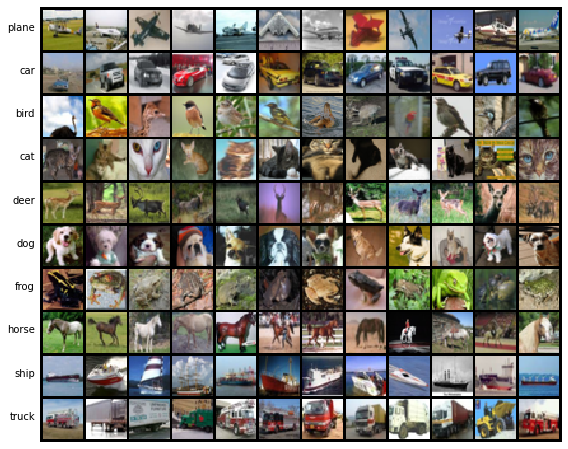

Train data shape:  torch.Size([47500, 3, 32, 32])
Train labels shape:  torch.Size([47500])
Validation data shape:  torch.Size([2500, 3, 32, 32])
Validation labels shape:  torch.Size([2500])
Test data shape:  torch.Size([10000, 3, 32, 32])
Test labels shape:  torch.Size([10000])


In [4]:
# Invoke the above function to get our data.
data_dict = get_CIFAR10_data(visualize=True)
print('Train data shape: ', data_dict['X_train'].shape)
print('Train labels shape: ', data_dict['y_train'].shape)
print('Validation data shape: ', data_dict['X_val'].shape)
print('Validation labels shape: ', data_dict['y_val'].shape)
print('Test data shape: ', data_dict['X_test'].shape)
print('Test labels shape: ', data_dict['y_test'].shape)

# Convolutional layer
As in the previous notebook, we will package each new neural network operator in a class that defines a `forward` and `backward` function.

In [5]:
class Conv(object):

  @staticmethod
  def forward(x, w, b, conv_param):
    raise NotImplementedError

  @staticmethod
  def backward(dout, cache):
    raise NotImplementedError

## Convolutional layer: forward
The core of a convolutional network is the convolution operation. Implement the forward pass for the convolution layer in the function `Conv.forward`. 

You don't have to worry too much about efficiency at this point; just write the code in whatever way you find most clear.

You can test your implementation by running the following:

In [6]:
def conv_forward(x, w, b, conv_param):
  """
  A naive implementation of the forward pass for a convolutional layer.
  The input consists of N data points, each with C channels, height H and
  width W. We convolve each input with F different filters, where each filter
  spans all C channels and has height HH and width WW.

  Input:
  - x: Input data of shape (N, C, H, W)
  - w: Filter weights of shape (F, C, HH, WW)
  - b: Biases, of shape (F,)
  - conv_param: A dictionary with the following keys:
    - 'stride': The number of pixels between adjacent receptive fields in the
    horizontal and vertical directions.
    - 'pad': The number of pixels that will be used to zero-pad the input. 
    
  During padding, 'pad' zeros should be placed symmetrically (i.e equally on both sides)
  along the height and width axes of the input. Be careful not to modfiy the original
  input x directly.

  Returns a tuple of:
  - out: Output data, of shape (N, F, H', W') where H' and W' are given by
    H' = 1 + (H + 2 * pad - HH) / stride
    W' = 1 + (W + 2 * pad - WW) / stride
  - cache: (x, w, b, conv_param)
  """
  out = None
  ##############################################################################
  # TODO: Implement the convolutional forward pass.                            #
  # Hint: you can use the function torch.nn.functional.pad for padding.        #
  # Note that you are NOT allowed to use anything in torch.nn in other places. #
  ##############################################################################
  # Replace "pass" statement with your code
  N,C,H,W = x.shape
  F,C,HH,WW = w.shape
  stride,pad = conv_param['stride'],conv_param['pad']
  H_ = 1+(H+2*pad-HH)//stride
  W_ = 1+(W+2*pad-WW)//stride
  out = torch.zeros((N,F,H_,W_),device = x.device,dtype=x.dtype)
  padding = torch.nn.functional.pad
  x_pad = padding(x, (pad, pad, pad, pad), mode='constant', value=0) 
  # pad the last two dimensions, default constant and zero
  for image in range(N): # each image
    for flr in range(F): # for each filter
      for i in range(H_): # row
        for j in range(W_): # column
          out[image, flr, i, j] = \
            torch.sum(x_pad[image, : , i*stride:i*stride+HH, j*stride:j*stride+WW] * w[flr, :, :, :]) + b[flr]
  #############################################################################
  #                              END OF YOUR CODE                             #
  #############################################################################
  cache = (x, w, b, conv_param)
  return out, cache

Conv.forward = conv_forward

After implementing the forward pass of the convolution operation, run the following to check your implementation. You should get a relative error less than `1e-7`.

In [15]:
x_shape = torch.tensor((2, 3, 4, 4))
w_shape = torch.tensor((3, 3, 4, 4))
x = torch.linspace(-0.1, 0.5, steps=torch.prod(x_shape), **to_double_cuda).reshape(*x_shape)
w = torch.linspace(-0.2, 0.3, steps=torch.prod(w_shape), **to_double_cuda).reshape(*w_shape)
b = torch.linspace(-0.1, 0.2, steps=3, **to_double_cuda)

conv_param = {'stride': 2, 'pad': 1}
out, _ = Conv.forward(x, w, b, conv_param)
correct_out = torch.tensor([[[[-0.08759809, -0.10987781],
                              [-0.18387192, -0.2109216 ]],
                             [[ 0.21027089,  0.21661097],
                              [ 0.22847626,  0.23004637]],
                             [[ 0.50813986,  0.54309974],
                              [ 0.64082444,  0.67101435]]],
                            [[[-0.98053589, -1.03143541],
                              [-1.19128892, -1.24695841]],
                             [[ 0.69108355,  0.66880383],
                              [ 0.59480972,  0.56776003]],
                             [[ 2.36270298,  2.36904306],
                              [ 2.38090835,  2.38247847]]]], **to_double_cuda)

# Compare your output to ours; difference should be around e-8
print('Testing Conv.forward')
print('difference: ', eecs598.grad.rel_error(out, correct_out))

Testing Conv.forward
difference:  1.0141824738238694e-09


## Aside: Image processing via convolutions

As fun way to both check your implementation and gain a better understanding of the type of operation that convolutional layers can perform, we will set up an input containing two images and manually set up filters that perform common image processing operations (grayscale conversion and edge detection). The convolution forward pass will apply these operations to each of the input images. We can then visualize the results as a sanity check.

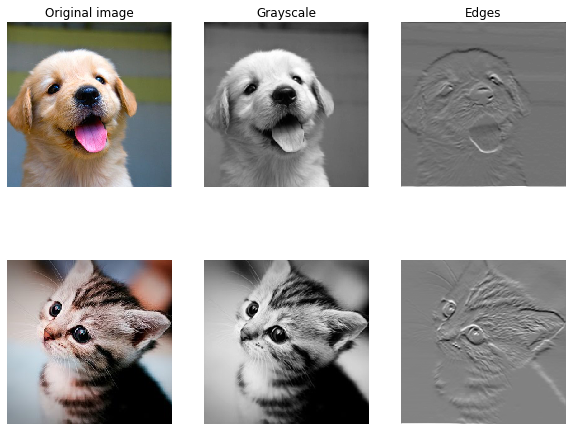

In [ ]:
from imageio import imread
from PIL import Image
from torchvision.transforms import ToTensor

kitten_url = 'https://web.eecs.umich.edu/~justincj/teaching/eecs498/assets/a3/kitten.jpg'
puppy_url = 'https://web.eecs.umich.edu/~justincj/teaching/eecs498/assets/a3/puppy.jpg'

kitten = imread(kitten_url)
puppy = imread(puppy_url)
# kitten is wide, and puppy is already square
d = kitten.shape[1] - kitten.shape[0]
kitten_cropped = kitten[:, d//2:-d//2, :]

img_size = 200   # Make this smaller if it runs too slow
resized_puppy = ToTensor()(Image.fromarray(puppy).resize((img_size, img_size)))
resized_kitten = ToTensor()(Image.fromarray(kitten_cropped).resize((img_size, img_size)))
x = torch.stack([resized_puppy, resized_kitten])

# Set up a convolutional weights holding 2 filters, each 3x3
w = torch.zeros(2, 3, 3, 3, dtype=x.dtype)

# The first filter converts the image to grayscale.
# Set up the red, green, and blue channels of the filter.
w[0, 0, :, :] = torch.tensor([[0, 0, 0], [0, 0.3, 0], [0, 0, 0]])
w[0, 1, :, :] = torch.tensor([[0, 0, 0], [0, 0.6, 0], [0, 0, 0]])
w[0, 2, :, :] = torch.tensor([[0, 0, 0], [0, 0.1, 0], [0, 0, 0]])

# Second filter detects horizontal edges in the blue channel.
w[1, 2, :, :] = torch.tensor([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

# Vector of biases. We don't need any bias for the grayscale
# filter, but for the edge detection filter we want to add 128
# to each output so that nothing is negative.
b = torch.tensor([0, 128], dtype=x.dtype)

# Compute the result of convolving each input in x with each filter in w,
# offsetting by b, and storing the results in out.
out, _ = Conv.forward(x, w, b, {'stride': 1, 'pad': 1})

def imshow_no_ax(img, normalize=True):
  """ Tiny helper to show images as uint8 and remove axis labels """
  if normalize:
    img_max, img_min = img.max(), img.min()
    img = 255.0 * (img - img_min) / (img_max - img_min)
  plt.imshow(img)
  plt.gca().axis('off')

# Show the original images and the results of the conv operation
plt.subplot(2, 3, 1)
imshow_no_ax(puppy, normalize=False)
plt.title('Original image')
plt.subplot(2, 3, 2)
imshow_no_ax(out[0, 0])
plt.title('Grayscale')
plt.subplot(2, 3, 3)
imshow_no_ax(out[0, 1])
plt.title('Edges')
plt.subplot(2, 3, 4)
imshow_no_ax(kitten_cropped, normalize=False)
plt.subplot(2, 3, 5)
imshow_no_ax(out[1, 0])
plt.subplot(2, 3, 6)
imshow_no_ax(out[1, 1])
plt.show()

## Convolutional layer: backward
Implement the backward pass for the convolution operation in the function `Conv.backward`. Again, you don't need to worry too much about computational efficiency.

In [ ]:
def conv_backward(dout, cache):
  """
  A naive implementation of the backward pass for a convolutional layer.

  Inputs:
  - dout: Upstream derivatives.
  - cache: A tuple of (x, w, b, conv_param) as in conv_forward_naive

  Returns a tuple of:
  - dx: Gradient with respect to x
  - dw: Gradient with respect to w
  - db: Gradient with respect to b
  """
  dx, dw, db = None, None, None
  #############################################################################
  # TODO: Implement the convolutional backward pass.                          #
  #############################################################################
  # Replace "pass" statement with your code
  x, w, b, conv_param = cache
  N, C, H, W = x.shape
  F, _, HH, WW = w.shape
  _, _, H_out, W_out = dout.shape
  
  pad, stride = conv_param['pad'], conv_param['stride']
  padding = torch.nn.functional.pad
  x_pad = padding(x, (pad, pad, pad, pad), mode='constant', value=0)
  
  dx = torch.zeros_like(x_pad) # dx = dout * w
  dw = torch.zeros_like(w) # dw = dout * x
  db = torch.zeros_like(b)
  
  for img in range(N):
    for flr in range(F):
      db[flr] += torch.sum(dout[img, flr])
      for i in range(H_out):
        for j in range(W_out):
          dw[flr, :, :, :] += dout[img, flr, i, j] * \
             x_pad[img, : , i*stride:i*stride+HH, j*stride:j*stride+WW]
              # image patch
          dx[img, :, i*stride:i*stride+HH,j*stride:j*stride+WW]\
              += dout[img, flr, i, j] * w[flr, :, :, :]
  
  dx = dx[:, :, pad: H+pad, pad: W+pad] # only remain non-padding part
  #############################################################################
  #                              END OF YOUR CODE                             #
  #############################################################################
  return dx, dw, db

Conv.backward = conv_backward

After implementing the convolution backward pass, run the following to test your implementation. You should get errors less than `1e-8`.

In [ ]:
fix_random_seed(0)
x = torch.randn(4, 3, 5, 5, **to_double_cuda)
w = torch.randn(2, 3, 3, 3, **to_double_cuda)
b = torch.randn(2, **to_double_cuda)
dout = torch.randn(4, 2, 5, 5, **to_double_cuda)
conv_param = {'stride': 1, 'pad': 1}

dx_num = compute_numeric_gradient(lambda x: Conv.forward(x, w, b, conv_param)[0], x, dout)
dw_num = compute_numeric_gradient(lambda w: Conv.forward(x, w, b, conv_param)[0], w, dout)
db_num = compute_numeric_gradient(lambda b: Conv.forward(x, w, b, conv_param)[0], b, dout)

out, cache = Conv.forward(x, w, b, conv_param)
dx, dw, db = Conv.backward(dout, cache)

print('Testing Conv.backward function')
print('dx error: ', rel_error(dx, dx_num))
print('dw error: ', rel_error(dw, dw_num))
print('db error: ', rel_error(db, db_num))

Testing Conv.backward function
dx error:  9.701562019554127e-09
dw error:  7.925070432746186e-10
db error:  1.5480568584027298e-10


# Max-pooling

In [ ]:
class MaxPool(object):

  @staticmethod
  def forward(x, pool_param):
    raise NotImplementedError

  @staticmethod
  def backward(dout, cache):
    raise NotImplementedError

## Max-pooling: forward
Implement the forward pass for the max-pooling operation. Again, don't worry too much about computational efficiency.

In [ ]:
def max_pool_forward(x, pool_param):
  """
  A naive implementation of the forward pass for a max-pooling layer.

  Inputs:
  - x: Input data, of shape (N, C, H, W)
  - pool_param: dictionary with the following keys:
    - 'pool_height': The height of each pooling region
    - 'pool_width': The width of each pooling region
    - 'stride': The distance between adjacent pooling regions
  No padding is necessary here.

  Returns a tuple of:
  - out: Output data, of shape (N, C, H', W') where H' and W' are given by
    H' = 1 + (H - pool_height) / stride
    W' = 1 + (W - pool_width) / stride
  - cache: (x, pool_param)
  """
  out = None
  #############################################################################
  # TODO: Implement the max-pooling forward pass                              #
  #############################################################################
  # Replace "pass" statement with your code
  N, C, H, W = x.shape
  HH, WW = pool_param['pool_height'], pool_param['pool_width']
  stride = pool_param['stride']
  
  H_out = 1 + (H - HH) // stride
  W_out = 1 + (W - WW) // stride
  
  out = torch.zeros((N, C, H_out, W_out), device=x.device, dtype=x.dtype)
  for img in range(N):
    for channel in range(C):
      for i in range(H_out):
        for j in range(W_out):
          out[img, channel, i, j] = \
            torch.max(x[img, channel, i*stride:i*stride+HH, j*stride:j*stride+WW])
  #############################################################################
  #                              END OF YOUR CODE                             #
  #############################################################################
  cache = (x, pool_param)
  return out, cache

MaxPool.forward = max_pool_forward

After implementing the forward pass for max-pooling, run the following to check your implementation. You should get errors less than `1e-7`.

In [ ]:
x_shape = torch.tensor((2, 3, 4, 4))
x = torch.linspace(-0.3, 0.4, steps=torch.prod(x_shape), **to_double_cuda).reshape(*x_shape)
pool_param = {'pool_width': 2, 'pool_height': 2, 'stride': 2}

out, _ = MaxPool.forward(x, pool_param)

correct_out = torch.tensor([[[[-0.26315789, -0.24842105],
                              [-0.20421053, -0.18947368]],
                             [[-0.14526316, -0.13052632],
                              [-0.08631579, -0.07157895]],
                             [[-0.02736842, -0.01263158],
                              [ 0.03157895,  0.04631579]]],
                            [[[ 0.09052632,  0.10526316],
                              [ 0.14947368,  0.16421053]],
                             [[ 0.20842105,  0.22315789],
                              [ 0.26736842,  0.28210526]],
                             [[ 0.32631579,  0.34105263],
                              [ 0.38526316,  0.4       ]]]], **to_double_cuda)

# Compare your output with ours. Difference should be on the order of e-8.
print('Testing MaxPool.forward function:')
print('difference: ', rel_error(out, correct_out))

Testing MaxPool.forward function:
difference:  8.333332667751512e-08


## Max-pooling: backward
Implement the backward pass for the max-pooling operation. You don't need to worry about computational efficiency.

In [ ]:
def max_pool_backward(dout, cache):
  """
  A naive implementation of the backward pass for a max-pooling layer.
  Inputs:
  - dout: Upstream derivatives
  - cache: A tuple of (x, pool_param) as in the forward pass.
  Returns:
  - dx: Gradient with respect to x
  """
  dx = None
  #############################################################################
  # TODO: Implement the max-pooling backward pass                             #
  #############################################################################
  # Replace "pass" statement with your code
  x, pool_param = cache
  N, C, H, W = x.shape
  HH, WW = pool_param['pool_height'], pool_param['pool_width']
  stride = pool_param['stride']
  _, _, H_out, W_out = dout.shape
  dx = torch.zeros_like(x)
  
  for img in range(N):
    for c in range(C):
      for i in range(H_out):
        for j in range(W_out):
          img_window = x[img, c, i*stride:i*stride+HH, j*stride:j*stride+WW]
          max_idx = torch.argmax(img_window)
          row = max_idx // img_window.shape[0]
          column = max_idx % img_window.shape[1]
          dx[img, c, i*stride:i*stride+HH, j*stride:j*stride+WW][row, column] = \
    				dout[img, c, i, j]
  #############################################################################
  #                              END OF YOUR CODE                             #
  #############################################################################
  return dx

MaxPool.backward = max_pool_backward

Check your implementation of the max pooling backward pass with numeric gradient checking by running the following. You should get errors less than `1e-10`.

In [ ]:
fix_random_seed(0)
x = torch.randn(3, 2, 8, 8, **to_double_cuda)
dout = torch.randn(3, 2, 4, 4, **to_double_cuda)
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

dx_num = compute_numeric_gradient(lambda x: MaxPool.forward(x, pool_param)[0], x, dout)

out, cache = MaxPool.forward(x, pool_param)
dx = MaxPool.backward(dout, cache)

print('Testing MaxPool.backward function:')
print('dx error: ', rel_error(dx, dx_num))

Testing MaxPool.backward function:
dx error:  6.551073432532464e-12


# Fast layers
Making convolution and pooling layers fast can be challenging. To spare you the pain, we've provided fast implementations of the forward and backward passes for convolution and pooling layers.

The fast convolution implementation depends on `torch.nn`

The API for the fast versions of the convolution and pooling layers is exactly the same as the naive versions that you implemented above: the forward pass receives data, weights, and parameters and produces outputs and a cache object; the backward pass recieves upstream derivatives and the cache object and produces gradients with respect to the data and weights.

You can compare the performance of the naive and fast versions of these layers by running the following:

In [16]:
class FastConv(object):

  @staticmethod
  def forward(x, w, b, conv_param):
    N, C, H, W = x.shape
    F, _, HH, WW = w.shape
    stride, pad = conv_param['stride'], conv_param['pad']
    layer = torch.nn.Conv2d(C, F, (HH, WW), stride=stride, padding=pad)
    layer.weight = torch.nn.Parameter(w)
    layer.bias = torch.nn.Parameter(b)
    tx = x.detach()
    tx.requires_grad = True
    out = layer(tx)
    cache = (x, w, b, conv_param, tx, out, layer)
    return out, cache

  @staticmethod
  def backward(dout, cache):
    try:
      x, _, _, _, tx, out, layer = cache
      out.backward(dout)
      dx = tx.grad.detach()
      dw = layer.weight.grad.detach()
      db = layer.bias.grad.detach()
      layer.weight.grad = layer.bias.grad = None
    except RuntimeError:
      dx, dw, db = torch.zeros_like(tx), torch.zeros_like(layer.weight), torch.zeros_like(layer.bias)
    return dx, dw, db
 
 
class FastMaxPool(object):

  @staticmethod
  def forward(x, pool_param):
    N, C, H, W = x.shape
    pool_height, pool_width = pool_param['pool_height'], pool_param['pool_width']
    stride = pool_param['stride']
    layer = torch.nn.MaxPool2d(kernel_size=(pool_height, pool_width), stride=stride)
    tx = x.detach()
    tx.requires_grad = True
    out = layer(tx)
    cache = (x, pool_param, tx, out, layer)
    return out, cache

  @staticmethod
  def backward(dout, cache):
    try:
      x, _, tx, out, layer = cache
      out.backward(dout)
      dx = tx.grad.detach()
    except RuntimeError:
      dx = torch.zeros_like(tx)
    return dx

We will now compare three different implementations of convolution (both forward and backward):

1. Your naive, non-vectorized implementation on CPU
2. The fast, vectorized implementation on CPU
3. The fast, vectorized implementation on GPU

The differences between your implementation and FastConv should be less than `1e-10`. When moving from your implementation to FastConv CPU, you will likely see speedups of at least 100x. When comparing your implementation to FastConv CUDA, you will likely see speedups of more than 500x. (These speedups are not hard requirements for this assignment since we are not asking you to write any vectorized implementations)

In [17]:
# Rel errors should be around e-11 or less
fix_random_seed(0)
x = torch.randn(10, 3, 31, 31, **to_double)
w = torch.randn(25, 3, 3, 3, **to_double)
b = torch.randn(25, **to_double)
dout = torch.randn(10, 25, 16, 16, **to_double)
x_cuda, w_cuda, b_cuda, dout_cuda = x.to('cuda'), w.to('cuda'), b.to('cuda'), dout.to('cuda')
conv_param = {'stride': 2, 'pad': 1}

t0 = time.time()
out_naive, cache_naive = Conv.forward(x, w, b, conv_param)
t1 = time.time()
out_fast, cache_fast = FastConv.forward(x, w, b, conv_param)
t2 = time.time()
out_fast_cuda, cache_fast_cuda = FastConv.forward(x_cuda, w_cuda, b_cuda, conv_param)
t3 = time.time()

print('Testing FastConv.forward:')
print('Naive: %fs' % (t1 - t0))
print('Fast: %fs' % (t2 - t1))
print('Fast CUDA: %fs' % (t3 - t2))
print('Speedup: %fx' % ((t1 - t0) / (t2 - t1)))
print('Speedup CUDA: %fx' % ((t1 - t0) / (t3 - t2)))
print('Difference: ', rel_error(out_naive, out_fast))
print('Difference CUDA: ', rel_error(out_naive, out_fast_cuda.to(out_naive.device)))

t0 = time.time()
dx_naive, dw_naive, db_naive = Conv.backward(dout, cache_naive)
t1 = time.time()
dx_fast, dw_fast, db_fast = FastConv.backward(dout, cache_fast)
t2 = time.time()
dx_fast_cuda, dw_fast_cuda, db_fast_cuda = FastConv.backward(dout_cuda, cache_fast_cuda)
t3 = time.time()

print('\nTesting FastConv.backward:')
print('Naive: %fs' % (t1 - t0))
print('Fast: %fs' % (t2 - t1))
print('Fast CUDA: %fs' % (t3 - t2))
print('Speedup: %fx' % ((t1 - t0) / (t2 - t1)))
print('Speedup CUDA: %fx' % ((t1 - t0) / (t3 - t2)))
print('dx difference: ', rel_error(dx_naive, dx_fast))
print('dw difference: ', rel_error(dw_naive, dw_fast))
print('db difference: ', rel_error(db_naive, db_fast))
print('dx difference CUDA: ', rel_error(dx_naive, dx_fast_cuda.to(dx_naive.device)))
print('dw difference CUDA: ', rel_error(dw_naive, dw_fast_cuda.to(dw_naive.device)))
print('db difference CUDA: ', rel_error(db_naive, db_fast_cuda.to(db_naive.device)))

NameError: ignored

We will now similarly compare your naive implementation of max pooling against the fast implementation. You should see differences of 0 between your implementation and the fast implementation.

When comparing your implementation against FastMaxPool on CPU, you will likely see speedups of more than 100x. When comparing your implementation against FastMaxPool on GPU, you will likely see speedups of more than 500x.

In [ ]:
# Relative errors should be close to 0.0
fix_random_seed(0)
x = torch.randn(40, 3, 32, 32, **to_double)
dout = torch.randn(40, 3, 16, 16, **to_double)
x_cuda, dout_cuda = x.to('cuda'), dout.to('cuda')
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

t0 = time.time()
out_naive, cache_naive = MaxPool.forward(x, pool_param)
t1 = time.time()
out_fast, cache_fast = FastMaxPool.forward(x, pool_param)
t2 = time.time()
out_fast_cuda, cache_fast_cuda = FastMaxPool.forward(x_cuda, pool_param)
t3 = time.time()

print('Testing FastMaxPool.forward:')
print('Naive: %fs' % (t1 - t0))
print('Fast: %fs' % (t2 - t1))
print('Fast CUDA: %fs' % (t3 - t2))
print('Speedup: %fx' % ((t1 - t0) / (t2 - t1)))
print('Speedup CUDA: %fx' % ((t1 - t0) / (t3 - t2)))
print('Difference: ', rel_error(out_naive, out_fast))
print('Difference CUDA: ', rel_error(out_naive, out_fast_cuda.to(out_naive.device)))

t0 = time.time()
dx_naive = MaxPool.backward(dout, cache_naive)
t1 = time.time()
dx_fast = FastMaxPool.backward(dout, cache_fast)
t2 = time.time()
dx_fast_cuda = FastMaxPool.backward(dout_cuda, cache_fast_cuda)
t3 = time.time()

print('\nTesting FastMaxPool.backward:')
print('Naive: %fs' % (t1 - t0))
print('Fast: %fs' % (t2 - t1))
print('Fast CUDA: %fs' % (t3 - t2))
print('Speedup: %fx' % ((t1 - t0) / (t2 - t1)))
print('Speedup CUDA: %fx' % ((t1 - t0) / (t3 - t2)))
print('dx difference: ', rel_error(dx_naive, dx_fast))
print('dx difference CUDA: ', rel_error(dx_naive, dx_fast_cuda.to(dx_naive.device)))

Testing FastMaxPool.forward:
Naive: 0.727381s
Fast: 0.001468s
Fast CUDA: 0.000561s
Speedup: 495.430172x
Speedup CUDA: 1295.481529x
Difference:  0.0
Difference CUDA:  0.0

Testing FastMaxPool.backward:
Naive: 1.684047s
Fast: 0.000989s
Fast CUDA: 0.000377s
Speedup: 1702.845468x
Speedup CUDA: 4470.508228x
dx difference:  0.0
dx difference CUDA:  0.0


# Convolutional "sandwich" layers
Previously we introduced the concept of "sandwich" layers that combine multiple operations into commonly used patterns. Below you will find sandwich layers that implement a few commonly used patterns for convolutional networks. Run the cells below to sanity check they're working.

In [18]:
class Conv_ReLU(object):

  @staticmethod
  def forward(x, w, b, conv_param):
    """
    A convenience layer that performs a convolution followed by a ReLU.
    Inputs:
    - x: Input to the convolutional layer
    - w, b, conv_param: Weights and parameters for the convolutional layer
    Returns a tuple of:
    - out: Output from the ReLU
    - cache: Object to give to the backward pass
    """
    a, conv_cache = FastConv.forward(x, w, b, conv_param)
    out, relu_cache = ReLU.forward(a)
    cache = (conv_cache, relu_cache)
    return out, cache

  @staticmethod
  def backward(dout, cache):
    """
    Backward pass for the conv-relu convenience layer.
    """
    conv_cache, relu_cache = cache
    da = ReLU.backward(dout, relu_cache)
    dx, dw, db = FastConv.backward(da, conv_cache)
    return dx, dw, db


class Conv_ReLU_Pool(object):

  @staticmethod
  def forward(x, w, b, conv_param, pool_param):
    """
    A convenience layer that performs a convolution, a ReLU, and a pool.
    Inputs:
    - x: Input to the convolutional layer
    - w, b, conv_param: Weights and parameters for the convolutional layer
    - pool_param: Parameters for the pooling layer
    Returns a tuple of:
    - out: Output from the pooling layer
    - cache: Object to give to the backward pass
    """
    a, conv_cache = FastConv.forward(x, w, b, conv_param)
    s, relu_cache = ReLU.forward(a)
    out, pool_cache = FastMaxPool.forward(s, pool_param)
    cache = (conv_cache, relu_cache, pool_cache)
    return out, cache

  @staticmethod
  def backward(dout, cache):
    """
    Backward pass for the conv-relu-pool convenience layer
    """
    conv_cache, relu_cache, pool_cache = cache
    ds = FastMaxPool.backward(dout, pool_cache)
    da = ReLU.backward(ds, relu_cache)
    dx, dw, db = FastConv.backward(da, conv_cache)
    return dx, dw, db

Test the implementations of the sandwich layers by running the following. You should see errors less than `1e-7`.

In [22]:
reset_seed(0)

# Test Conv ReLU
x = torch.randn(2, 3, 8, 8, dtype=torch.float64, device='cuda')
w = torch.randn(3, 3, 3, 3, dtype=torch.float64, device='cuda')
b = torch.randn(3, dtype=torch.float64, device='cuda')
dout = torch.randn(2, 3, 8, 8, dtype=torch.float64, device='cuda')
conv_param = {'stride': 1, 'pad': 1}

out, cache = Conv_ReLU.forward(x, w, b, conv_param)
# print(out)
dx, dw, db = Conv_ReLU.backward(dout, cache)

dx_num = eecs598.grad.compute_numeric_gradient(lambda x: Conv_ReLU.forward(x, w, b, conv_param)[0], x, dout)
dw_num = eecs598.grad.compute_numeric_gradient(lambda w: Conv_ReLU.forward(x, w, b, conv_param)[0], w, dout)
db_num = eecs598.grad.compute_numeric_gradient(lambda b: Conv_ReLU.forward(x, w, b, conv_param)[0], b, dout)
# print(dx)
# Relative errors should be around e-8 or less
print('Testing Conv_ReLU:')
print('dx error: ', eecs598.grad.rel_error(dx_num, dx))
print('dw error: ', eecs598.grad.rel_error(dw_num, dw))
print('db error: ', eecs598.grad.rel_error(db_num, db))

# Test Conv ReLU Pool
x = torch.randn(2, 3, 16, 16, dtype=torch.float64, device='cuda')
w = torch.randn(3, 3, 3, 3, dtype=torch.float64, device='cuda')
b = torch.randn(3, dtype=torch.float64, device='cuda')
dout = torch.randn(2, 3, 8, 8, dtype=torch.float64, device='cuda')
conv_param = {'stride': 1, 'pad': 1}
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

out, cache = Conv_ReLU_Pool.forward(x, w, b, conv_param, pool_param)
dx, dw, db = Conv_ReLU_Pool.backward(dout, cache)

dx_num = eecs598.grad.compute_numeric_gradient(lambda x: Conv_ReLU_Pool.forward(x, w, b, conv_param, pool_param)[0], x, dout)
dw_num = eecs598.grad.compute_numeric_gradient(lambda w: Conv_ReLU_Pool.forward(x, w, b, conv_param, pool_param)[0], w, dout)
db_num = eecs598.grad.compute_numeric_gradient(lambda b: Conv_ReLU_Pool.forward(x, w, b, conv_param, pool_param)[0], b, dout)

# Relative errors should be around e-8 or less
print()
print('Testing Conv_ReLU_Pool')
print('dx error: ', eecs598.grad.rel_error(dx_num, dx))
print('dw error: ', eecs598.grad.rel_error(dw_num, dw))
print('db error: ', eecs598.grad.rel_error(db_num, db))

/tmp/tmpriv4dobv.ipynb:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Testing Conv_ReLU:
dx error:  1.803700145878108e-09
dw error:  1.2470996630795975e-09
db error:  1.1230402096612364e-09

Testing Conv_ReLU_Pool
dx error:  1.5915037060449427e-09
dw error:  1.8962680574409507e-09
db error:  5.05984212319748e-09


# Three-layer convolutional network
Now that you have implemented all the necessary layers, we can put them together into a simple convolutional network.

Complete the implementation of the `ThreeLayerConvNet` class. We STRONGLY recommend you to use the fast/sandwich layers (already imported for you) in your implementation. Run the following cells to help you debug:

In [ ]:
class ThreeLayerConvNet(object):
  """
  A three-layer convolutional network with the following architecture:
  conv - relu - 2x2 max pool - linear - relu - linear - softmax
  The network operates on minibatches of data that have shape (N, C, H, W)
  consisting of N images, each with height H and width W and with C input
  channels.
  """

  def __init__(self, input_dims=(3, 32, 32), num_filters=32, filter_size=7,
         hidden_dim=100, num_classes=10, weight_scale=1e-3, reg=0.0,
         dtype=torch.float, device='cpu'):
    """
    Initialize a new network.
    Inputs:
    - input_dims: Tuple (C, H, W) giving size of input data
    - num_filters: Number of filters to use in the convolutional layer
    - filter_size: Width/height of filters to use in the convolutional layer
    - hidden_dim: Number of units to use in the fully-connected hidden layer
    - num_classes: Number of scores to produce from the final linear layer.
    - weight_scale: Scalar giving standard deviation for random initialization
      of weights.
    - reg: Scalar giving L2 regularization strength
    - dtype: A torch data type object; all computations will be performed using
      this datatype. float is faster but less accurate, so you should use
      double for numeric gradient checking.
    - device: device to use for computation. 'cpu' or 'cuda'
    
  Input:
  - x: Input data of shape (N, C, H, W)
  - w: Filter weights of shape (F, C, HH, WW)
  - b: Biases, of shape (F,)
  - conv_param: A dictionary with the following keys:
    - 'stride': The number of pixels between adjacent receptive fields in the
    horizontal and vertical directions.
    - 'pad': The number of pixels that will be used to zero-pad the input. 
    """
    self.params = {}
    self.reg = reg
    self.dtype = dtype
    self.device = device
    self.L = 3
    ############################################################################
    # TODO: Initialize weights and biases for the three-layer convolutional    #
    # network. Weights should be initialized from a Gaussian centered at 0.0   #
    # with standard deviation equal to weight_scale; biases should be          #
    # initialized to zero. All weights and biases should be stored in the      #
    #  dictionary self.params. Store weights and biases for the convolutional  #
    # layer using the keys 'W1' and 'b1'; use keys 'W2' and 'b2' for the       #
    # weights and biases of the hidden linear layer, and keys 'W3' and 'b3'    #
    # for the weights and biases of the output linear layer.                   #
    #                                                                          #
    # IMPORTANT: For this assignment, you can assume that the padding          #
    # and stride of the first convolutional layer are chosen so that           #
    # **the width and height of the input are preserved**. Take a look at      #
    # the start of the loss() function to see how that happens.                #               
    ############################################################################
    # Replace "pass" statement with your code
    C,H,W = input_dims
    self.params['W1']= torch.normal(0.0,weight_scale,(num_filters,C,filter_size,filter_size),device=self.device,dtype=self.dtype)
    self.params['b1']= torch.zeros(num_filters,device=self.device,dtype=self.dtype)

    self.params['W2']= torch.normal(0.0,weight_scale,(H*W*num_filters//4,hidden_dim),device=self.device,dtype=self.dtype)
    self.params['b2']= torch.zeros(hidden_dim,device=self.device,dtype=self.dtype)

    self.params['W3']= torch.normal(0.0,weight_scale,(hidden_dim,num_classes),device=self.device,dtype=self.dtype)
    self.params['b3']= torch.zeros(num_classes,device=self.device,dtype=self.dtype)
    ############################################################################
    #                             END OF YOUR CODE                             #
    ############################################################################


  def loss(self, X, y=None):
    """
    Evaluate loss and gradient for the three-layer convolutional network.
    Input / output: Same API as TwoLayerNet.
    """
    X = X.to(self.dtype)
    W1, b1 = self.params['W1'], self.params['b1']
    W2, b2 = self.params['W2'], self.params['b2']
    W3, b3 = self.params['W3'], self.params['b3']

    # pass conv_param to the forward pass for the convolutional layer
    # Padding and stride chosen to preserve the input spatial size
    filter_size = W1.shape[2]
    conv_param = {'stride': 1, 'pad': (filter_size - 1) // 2}

    # pass pool_param to the forward pass for the max-pooling layer
    pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

    scores = None
    caches = []
    ############################################################################
    # TODO: Implement the forward pass for the three-layer convolutional net,  #
    # computing the class scores for X and storing them in the scores          #
    # variable.                                                                #
    #                                                                          #
    # Remember you can use the functions defined in your implementation above. #
    ############################################################################
    # Replace "pass" statement with your code
    out1, cache1 = Conv_ReLU_Pool.forward(X, W1, b1, conv_param, pool_param)
    caches.append(cache1)
    
    out2, cache2 = Linear_ReLU.forward(out1, W2, b2)
    caches.append(cache2)
    
    out3, fc_cache = Linear.forward(out2, W3, b3)
    caches.append(fc_cache)
    
    scores = out3

    ############################################################################
    #                             END OF YOUR CODE                             #
    ############################################################################

    if y is None:
      return scores

    loss, grads = 0.0, {}
    ############################################################################
    # TODO: Implement the backward pass for the three-layer convolutional net, #
    # storing the loss and gradients in the loss and grads variables. Compute  #
    # data loss using softmax, and make sure that grads[k] holds the gradients #
    # for self.params[k]. Don't forget to add L2 regularization!               #
    #                                                                          #
    # NOTE: To ensure that your implementation matches ours and you pass the   #
    # automated tests, make sure that your L2 regularization does not include  #
    # a factor of 0.5                                                          #
    ############################################################################
    # Replace "pass" statement with your code
    loss,dx = softmax_loss(scores,y)
    for i in range(3): #3 layers
      w = self.params['W' + str(i+1)]
      loss += self.reg * torch.sum(w ** 2)

    dout, dwL, dbL = Linear.backward(dx, caches.pop())
    grads['W'+str(self.L)] = dwL + 2*self.reg*self.params['W'+str(self.L)] 
    grads['b'+str(self.L)] = dbL

    dout, dw2, db2 = Linear_ReLU.backward(dout,caches.pop())
    grads['W'+str(self.L-1)] = dw2+ 2*self.reg*self.params['W'+str(self.L-1)]
    grads['b'+str(self.L-1)] = db2
    
    dout,dw1,db1 = Conv_ReLU_Pool.backward(dout, caches.pop())
    grads['W'+str(self.L-2)] = dw1+ 2*self.reg*self.params['W'+str(self.L-2)]
    grads['b'+str(self.L-2)] = db1
    ############################################################################
    #                             END OF YOUR CODE                             #
    ############################################################################

    return loss, grads

## Sanity check loss
After you build a new network, one of the first things you should do is sanity check the loss. When we use the softmax loss, we expect the loss for random weights (and no regularization) to be about `log(C)` for `C` classes. When we add regularization the loss should go up slightly.

In [ ]:
fix_random_seed(0)
model = ThreeLayerConvNet(**to_double_cuda)

N = 50
X = torch.randn(N, 3, 32, 32, **to_double_cuda)
y = torch.randint(10, size=(N,), **to_long_cuda)

loss, grads = model.loss(X, y)
print('Initial loss (no regularization): ', loss.item())

model.reg = 0.5
loss, grads = model.loss(X, y)
print('Initial loss (with regularization): ', loss.item())

Initial loss (no regularization):  2.302584070548802
Initial loss (with regularization):  2.7153611607714265


/tmp/tmpdp936zzg.ipynb:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


## Gradient check
After the loss looks reasonable, use numeric gradient checking to make sure that your backward pass is correct. When you use numeric gradient checking you should use a small amount of artificial data and a small number of neurons at each layer.

You should see errors less than `1e-5`.

In [ ]:
num_inputs = 2
input_dims = (3, 16, 16)
reg = 0.0
num_classes = 10
fix_random_seed(0)
X = torch.randn(num_inputs, *input_dims, **to_double_cuda)
y = torch.randint(num_classes, size=(num_inputs,), **to_long_cuda)

model = ThreeLayerConvNet(num_filters=3, filter_size=3,
                          input_dims=input_dims, hidden_dim=7,
                          weight_scale=5e-2, **to_double_cuda)
loss, grads = model.loss(X, y)

for param_name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    param_grad_num = compute_numeric_gradient(f, model.params[param_name])
    print('%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name])))

/tmp/tmpdp936zzg.ipynb:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


W1 max relative error: 2.941823e-07
W2 max relative error: 3.446385e-06
W3 max relative error: 7.784394e-10
b1 max relative error: 4.311863e-09
b2 max relative error: 3.954465e-09
b3 max relative error: 2.169956e-10


## Overfit small data
A nice trick is to train your model with just a few training samples. You should be able to overfit small datasets, which will result in very high training accuracy and comparatively low validation accuracy.

In [ ]:
fix_random_seed(0)

num_train = 100
small_data = {
  'X_train': data_dict['X_train'][:num_train],
  'y_train': data_dict['y_train'][:num_train],
  'X_val': data_dict['X_val'],
  'y_val': data_dict['y_val'],
}

model = ThreeLayerConvNet(weight_scale=1e-3, **to_float_cuda)

solver = Solver(model, small_data,
                num_epochs=30, batch_size=50,
                update_rule=adam,
                optim_config={
                  'learning_rate': 2e-3,
                },
                verbose=True, print_every=1,
                device='cuda')
solver.train()

(Time 0.02 sec; Iteration 1 / 60) loss: 2.302585


/tmp/tmpdp936zzg.ipynb:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


(Epoch 0 / 30) train acc: 0.160000; val_acc: 0.098800
(Time 0.11 sec; Iteration 2 / 60) loss: 2.300490
(Epoch 1 / 30) train acc: 0.160000; val_acc: 0.098800
(Time 0.20 sec; Iteration 3 / 60) loss: 2.286961
(Time 0.20 sec; Iteration 4 / 60) loss: 2.243166
(Epoch 2 / 30) train acc: 0.160000; val_acc: 0.098800
(Time 0.28 sec; Iteration 5 / 60) loss: 2.207949
(Time 0.28 sec; Iteration 6 / 60) loss: 2.199701
(Epoch 3 / 30) train acc: 0.180000; val_acc: 0.095200
(Time 0.36 sec; Iteration 7 / 60) loss: 2.190146
(Time 0.36 sec; Iteration 8 / 60) loss: 2.081954
(Epoch 4 / 30) train acc: 0.190000; val_acc: 0.128000
(Time 0.43 sec; Iteration 9 / 60) loss: 2.171695
(Time 0.44 sec; Iteration 10 / 60) loss: 2.089214
(Epoch 5 / 30) train acc: 0.230000; val_acc: 0.129600
(Time 0.51 sec; Iteration 11 / 60) loss: 2.093825
(Time 0.52 sec; Iteration 12 / 60) loss: 2.009098
(Epoch 6 / 30) train acc: 0.260000; val_acc: 0.139200
(Time 0.59 sec; Iteration 13 / 60) loss: 2.025605
(Time 0.60 sec; Iteration 14 /

Plotting the loss, training accuracy, and validation accuracy should show clear overfitting:

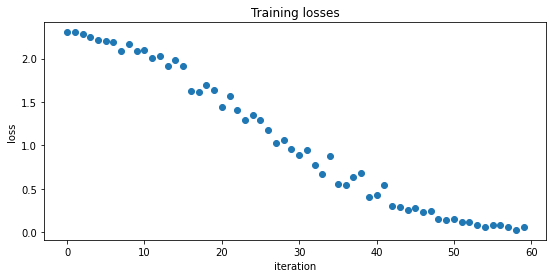

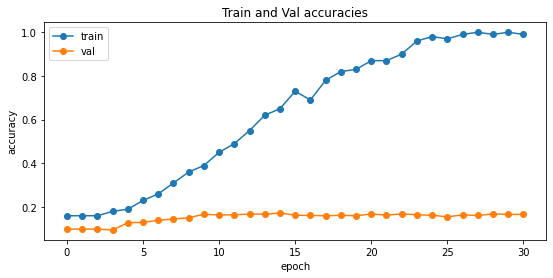

In [ ]:
plt.title('Training losses')
plt.plot(solver.loss_history, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.gcf().set_size_inches(9, 4)
plt.show()

plt.title('Train and Val accuracies')
plt.plot(solver.train_acc_history, '-o')
plt.plot(solver.val_acc_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.gcf().set_size_inches(9, 4)
plt.show()

## Train the net
By training the three-layer convolutional network for one epoch, you should achieve greater than 50% accuracy on the training set:

In [ ]:
fix_random_seed(0)

model = ThreeLayerConvNet(weight_scale=0.001, hidden_dim=500, reg=0.001, dtype=torch.float, device='cuda')

solver = Solver(model, data_dict,
                num_epochs=1, batch_size=64,
                update_rule=adam,
                optim_config={
                  'learning_rate': 2e-3,
                },
                verbose=True, print_every=50, device='cuda')
solver.train()

/tmp/tmpdp936zzg.ipynb:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


(Time 0.01 sec; Iteration 1 / 742) loss: 2.306691
(Epoch 0 / 1) train acc: 0.111000; val_acc: 0.100400
(Time 0.50 sec; Iteration 51 / 742) loss: 1.942387
(Time 0.88 sec; Iteration 101 / 742) loss: 1.874947
(Time 1.26 sec; Iteration 151 / 742) loss: 1.846200
(Time 1.64 sec; Iteration 201 / 742) loss: 1.752293
(Time 2.01 sec; Iteration 251 / 742) loss: 1.685573
(Time 2.39 sec; Iteration 301 / 742) loss: 1.495159
(Time 2.76 sec; Iteration 351 / 742) loss: 1.637565
(Time 3.14 sec; Iteration 401 / 742) loss: 1.571144
(Time 3.52 sec; Iteration 451 / 742) loss: 1.892918
(Time 3.89 sec; Iteration 501 / 742) loss: 1.366028
(Time 4.27 sec; Iteration 551 / 742) loss: 1.721067
(Time 4.65 sec; Iteration 601 / 742) loss: 1.646603
(Time 5.03 sec; Iteration 651 / 742) loss: 1.746354
(Time 5.41 sec; Iteration 701 / 742) loss: 1.727055
(Epoch 1 / 1) train acc: 0.493000; val_acc: 0.487600


## Visualize Filters
You can visualize the first-layer convolutional filters from the trained network by running the following:

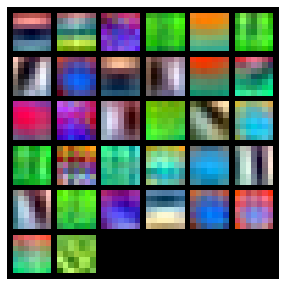

In [ ]:
from torchvision.utils import make_grid
nrow = math.ceil(math.sqrt(model.params['W1'].shape[0]))
grid = make_grid(model.params['W1'], nrow=nrow, padding=1, normalize=True, scale_each=True)
plt.imshow(grid.to(device='cpu').permute(1, 2, 0))
plt.axis('off')
plt.gcf().set_size_inches(5, 5)
plt.show()

# Deep convolutional network
Next you will implement a deep convolutional network with an arbitrary number of conv layers in VGGNet style.

Read through the `DeepConvNet` class.

Implement the initialization, the forward pass, and the backward pass. For the moment don't worry about implementing batch normalization; we will add those features soon. Again, we STRONGLY recommend you to use the fast/sandwich layers (already imported for you) in your implementation.

In [23]:
class DeepConvNet(object):
  """
  A convolutional neural network with an arbitrary number of convolutional
  layers in VGG-Net style. All convolution layers will use kernel size 3 and 
  padding 1 to preserve the feature map size, and all pooling layers will be
  max pooling layers with 2x2 receptive fields and a stride of 2 to halve the
  size of the feature map.

  The network will have the following architecture:
  
  {conv - [batchnorm?] - relu - [pool?]} x (L - 1) - linear

  Each {...} structure is a "macro layer" consisting of a convolution layer,
  an optional batch normalization layer, a ReLU nonlinearity, and an optional
  pooling layer. After L-1 such macro layers, a single fully-connected layer
  is used to predict the class scores.

  The network operates on minibatches of data that have shape (N, C, H, W)
  consisting of N images, each with height H and width W and with C input
  channels.
  """
  def __init__(self, input_dims=(3, 32, 32),
               num_filters=[8, 8, 8, 8, 8],
               max_pools=[0, 1, 2, 3, 4],
               batchnorm=False,
               num_classes=10, weight_scale=1e-3, reg=0.0,
               weight_initializer=None,
               dtype=torch.float, device='cpu'):
    """
    Initialize a new network.

    Inputs:
    - input_dims: Tuple (C, H, W) giving size of input data
    - num_filters: List of length (L - 1) giving the number of convolutional
      filters to use in each macro layer.
    - max_pools: List of integers giving the indices of the macro layers that
      should have max pooling (zero-indexed).
    - batchnorm: Whether to include batch normalization in each macro layer
    - num_classes: Number of scores to produce from the final linear layer.
    - weight_scale: Scalar giving standard deviation for random initialization
      of weights, or the string "kaiming" to use Kaiming initialization instead
    - reg: Scalar giving L2 regularization strength. L2 regularization should
      only be applied to convolutional and fully-connected weight matrices;
      it should not be applied to biases or to batchnorm scale and shifts.
    - dtype: A torch data type object; all computations will be performed using
      this datatype. float is faster but less accurate, so you should use
      double for numeric gradient checking.
    - device: device to use for computation. 'cpu' or 'cuda'    
    """
    self.params = {}
    self.num_layers = len(num_filters)+1
    self.max_pools = max_pools

    self.batchnorm = batchnorm

    self.reg = reg
    self.dtype = dtype
    self.L = 1+ len(num_filters)
    self.filter_size = 3

    if device == 'cuda':
      device = 'cuda:0'
    
    ############################################################################
    # TODO: Initialize the parameters for the DeepConvNet. All weights,        #
    # biases, and batchnorm scale and shift parameters should be stored in the #
    # dictionary self.params.                                                  #
    #                                                                          #
    # Weights for conv and fully-connected layers should be initialized        #
    # according to weight_scale. Biases should be initialized to zero.         #
    # Batchnorm scale (gamma) and shift (beta) parameters should be initilized #
    # to ones and zeros respectively.                                          #           
    ############################################################################
    # Replace "pass" statement with your code
    C,H,W = input_dims
    kaiming = weight_scale=='kaiming'
    for l in range(self.num_layers-1):
      # print("DEBUG test hidden_list:",l)
      if l == 0:
        #  print(weight_scale.dtype)
        if kaiming:
          self.params['W1'] = kaiming_initializer(C,num_filters[l],self.filter_size,relu=True,device=device,dtype=dtype)
        else:
          self.params['W1']= weight_scale*torch.randn((num_filters[l],C,self.filter_size,self.filter_size)).to(device).to(dtype)
        self.params['b1']= torch.zeros(num_filters[l],device=device,dtype=dtype)
      else:
        if kaiming:
          self.params['W%d'%(l+1)] = kaiming_initializer(num_filters[l-1],num_filters[l],self.filter_size,relu=True,device=device,dtype=dtype)
        else:
          self.params['W%d'%(l+1)] = weight_scale*torch.randn((num_filters[l],num_filters[l-1],self.filter_size,self.filter_size)).to(device).to(dtype)
        self.params['b%d'%(l+1)] = torch.zeros(num_filters[l],dtype=dtype,device=device)
    if self.batchnorm:
      for i in range(self.num_layers-1):
        self.params['gamma%d'%(i+1)] = torch.ones(num_filters[i],dtype=dtype,device=device)
        self.params['beta%d'%(i+1)] = torch.ones(num_filters[i],dtype=dtype,device=device)

    downsamplerate = 2**len(self.max_pools)
    if kaiming:
      self.params['W%d'%(self.L)] = kaiming_initializer(H*W*num_filters[-1]//downsamplerate**2, num_classes,device=device,dtype=dtype)
    else:
      self.params['W%d'%(self.L)] = weight_scale*torch.randn((H*W*num_filters[-1]//downsamplerate**2, num_classes)).to(device).to(dtype)
    self.params['b%d'%(self.L)] = torch.zeros(num_classes,dtype=dtype,device=device)
    ############################################################################
    #                             END OF YOUR CODE                             #
    ############################################################################

    # With batch normalization we need to keep track of running means and
    # variances, so we need to pass a special bn_param object to each batch
    # normalization layer. You should pass self.bn_params[0] to the forward pass
    # of the first batch normalization layer, self.bn_params[1] to the forward
    # pass of the second batch normalization layer, etc.
    self.bn_params = []
    if self.batchnorm:
      self.bn_params = [{'mode': 'train'} for _ in range(len(num_filters))]
      
    # Check that we got the right number of parameters
    if not self.batchnorm:
      params_per_macro_layer = 2  # weight and bias
    else:
      params_per_macro_layer = 4  # weight, bias, scale, shift
    num_params = params_per_macro_layer * len(num_filters) + 2
    msg = 'self.params has the wrong number of elements. Got %d; expected %d'
    msg = msg % (len(self.params), num_params)
    assert len(self.params) == num_params, msg

    # Check that all parameters have the correct device and dtype:
    for k, param in self.params.items():
      msg = 'param "%s" has device %r; should be %r' % (k, param.device, device)
      assert param.device == torch.device(device), msg
      msg = 'param "%s" has dtype %r; should be %r' % (k, param.dtype, dtype)
      assert param.dtype == dtype, msg

  def loss(self, X, y=None):
    """
    Evaluate loss and gradient for the deep convolutional network.
    Input / output: Same API as ThreeLayerConvNet.
    """
    X = X.to(self.dtype)
    mode = 'test' if y is None else 'train'

    # Set train/test mode for batchnorm params since they
    # behave differently during training and testing.
    if self.batchnorm:
      for bn_param in self.bn_params:
        bn_param['mode'] = mode
    scores = None

    # pass conv_param to the forward pass for the convolutional layer
    # Padding and stride chosen to preserve the input spatial size
    filter_size = 3
    conv_param = {'stride': 1, 'pad': (filter_size - 1) // 2}

    # pass pool_param to the forward pass for the max-pooling layer
    pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

    scores = None
    ############################################################################
    # TODO: Implement the forward pass for the DeepConvNet, computing the      #
    # class scores for X and storing them in the scores variable.              #
    #                                                                          #
    # You should use the fast versions of convolution and max pooling layers,  #
    # or the convolutional sandwich layers, to simplify your implementation.   #
    ############################################################################
    # Replace "pass" statement with your code

    '''
    out1, cache1 = Conv_ReLU_Pool.forward(X, W1, b1, conv_param, pool_param)
    caches.append(cache1)
    
    out2, cache2 = Linear_ReLU.forward(out1, W2, b2)
    caches.append(cache2)
    
    out3, fc_cache = Linear.forward(out2, W3, b3)
    caches.append(fc_cache)
    
    scores = out3
    '''

    dout = X
    caches = []
    drop_cache = []
    for l in range(self.num_layers-1):
      dout,cache_hidden = FastConv.forward(dout,self.params['W'+str(l+1)],self.params['b'+str(l+1)], conv_param)
      caches.append(cache_hidden)
      
      if self.batchnorm:
        dout, batch_cache = SpatialBatchNorm.forward(dout, self.params['gamma%d'%(l+1)], self.params['beta%d'%(l+1)], self.bn_params[l])
        caches.append(batch_cache)

      dout,cache_relu = ReLU.forward(dout)
      caches.append(cache_relu)

      if l in self.max_pools:
        dout,cache_maxpool = FastMaxPool.forward(dout,pool_param)
        caches.append(cache_maxpool)

    dout, before_loss_cache = Linear.forward(dout, self.params['W'+str(self.L)],self.params['b'+str(self.L)])
    caches.append(before_loss_cache)

    scores = dout
    ############################################################################
    #                             END OF YOUR CODE                             #
    ############################################################################

    if y is None:
      return scores

    loss, grads = 0, {}
    ############################################################################
    # TODO: Implement the backward pass for the DeepConvNet, storing the loss  #
    # and gradients in the loss and grads variables. Compute data loss using   #
    # softmax, and make sure that grads[k] holds the gradients for             #
    # self.params[k]. Don't forget to add L2 regularization!                   #
    #                                                                          #
    # NOTE: To ensure that your implementation matches ours and you pass the   #
    # automated tests, make sure that your L2 regularization does not include  #
    # a factor of 0.5                                                          #
    ############################################################################
    # Replace "pass" statement with your code
    loss,dx = softmax_loss(scores,y)
    for i in range(self.num_layers):
      w = self.params['W' + str(i+1)]
      loss += self.reg * torch.sum(w ** 2)
    
    dout, dwL, dbL = Linear.backward(dx, caches.pop())
    grads['W'+str(self.L)] = dwL + 2*self.reg*self.params['W'+str(self.L)] 
    grads['b'+str(self.L)] = dbL

    for l in reversed(range(self.num_layers-1)):
      # print("dZ:",da2.shape)
      # da_prev = da2
      # print("DEBUG L :",l)
      # print("DEBUG shape: ",l,self.params['W'+str(l+1)].shape)
      if l in self.max_pools:
        dout = FastMaxPool.backward(dout,caches.pop())
      dout = ReLU.backward(dout,caches.pop())
      if self.batchnorm:
        dout, dgamma, dbeta = SpatialBatchNorm.backward(dout, caches.pop())
        grads['gamma%d'%(l+1)] = dgamma
        grads['beta%d'%(l+1)] = dbeta

      dout, dw, db = FastConv.backward(dout,caches.pop())

      grads['W'+str(l+1)] = dw+ 2*self.reg*self.params['W'+str(l+1)]
      grads['b'+str(l+1)] = db

    ############################################################################
    #                             END OF YOUR CODE                             #
    ############################################################################

    return loss, grads

## Sanity check loss
After you build a new network, one of the first things you should do is sanity check the loss. When we use the softmax loss, we expect the loss for random weights (and no regularization) to be about `log(C)` for `C` classes. When we add regularization the loss should go up slightly.

In [ ]:
fix_random_seed(0)
input_dims = (3, 32, 32)
model = DeepConvNet(num_filters=[8, 64], max_pools=[0, 1], **to_double_cuda)

N = 50
X = torch.randn(N, *input_dims, **to_double_cuda)
y = torch.randint(10, size=(N,), **to_long_cuda)

loss, grads = model.loss(X, y)
print('Initial loss (no regularization): ', loss.item())

model.reg = 1.
loss, grads = model.loss(X, y)
print('Initial loss (with regularization): ', loss.item())

Initial loss (no regularization):  2.302584820952504
Initial loss (with regularization):  2.3484235261662056


/tmp/tmpdp936zzg.ipynb:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


## Gradient check
After the loss looks reasonable, use numeric gradient checking to make sure that your backward pass is correct. When you use numeric gradient checking you should use a small amount of artifical data and a small number of neurons at each layer.

For the check with reg=0, you should see relative errors less than `1e-5`. For the check with reg=3.14, you should see relative errors less than `1e-4`

In [ ]:
num_inputs = 2
input_dims = (3, 8, 8)
num_classes = 10
fix_random_seed(0)
X = torch.randn(num_inputs, *input_dims, **to_double_cuda)
y = torch.randint(num_classes, size=(num_inputs,), **to_long_cuda)

for reg in [0, 3.14]:
  print('Running check with reg = ', reg)
  model = DeepConvNet(input_dims=input_dims, num_classes=num_classes,
                      num_filters=[8, 8, 8],
                      max_pools=[0, 2],
                      reg=reg,
                      weight_scale=5e-2, **to_double_cuda)

  loss, grads = model.loss(X, y)
  # The relative errors should be up to the order of e-6
  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = compute_numeric_gradient(f, model.params[name])
    print('%s max relative error: %e' % (name, rel_error(grad_num, grads[name])))
  if reg == 0: print()

/tmp/tmpdp936zzg.ipynb:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Running check with reg =  0
W1 max relative error: 2.066206e-07
W2 max relative error: 3.108040e-04
W3 max relative error: 1.442974e-04
W4 max relative error: 6.790222e-08
b1 max relative error: 1.119736e-08
b2 max relative error: 8.384554e-09
b3 max relative error: 5.793960e-10
b4 max relative error: 2.341834e-10

Running check with reg =  3.14
W1 max relative error: 3.615345e-08
W2 max relative error: 7.536138e-08
W3 max relative error: 1.422302e-07
W4 max relative error: 3.363478e-07
b1 max relative error: 4.031461e-07
b2 max relative error: 6.987182e-08
b3 max relative error: 1.136460e-07
b4 max relative error: 1.316913e-09


## Overfit small data
As another sanity check, make sure you can overfit a small dataset of 50 images. In the following cell, tweak the **learning rate** and **weight initialization scale** to overfit and achieve 100% training accuracy within 30 epochs.

(Time 0.01 sec; Iteration 1 / 150) loss: 4.792116
(Epoch 0 / 30) train acc: 0.100000; val_acc: 0.078000


/tmp/tmpdp936zzg.ipynb:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


(Epoch 1 / 30) train acc: 0.200000; val_acc: 0.106400
(Epoch 2 / 30) train acc: 0.300000; val_acc: 0.117600
(Time 0.34 sec; Iteration 11 / 150) loss: 2.428176
(Epoch 3 / 30) train acc: 0.340000; val_acc: 0.122400
(Epoch 4 / 30) train acc: 0.480000; val_acc: 0.106800
(Time 0.58 sec; Iteration 21 / 150) loss: 1.870175
(Epoch 5 / 30) train acc: 0.540000; val_acc: 0.126000
(Epoch 6 / 30) train acc: 0.560000; val_acc: 0.132800
(Time 0.82 sec; Iteration 31 / 150) loss: 1.341227
(Epoch 7 / 30) train acc: 0.660000; val_acc: 0.127200
(Epoch 8 / 30) train acc: 0.800000; val_acc: 0.123200
(Time 1.07 sec; Iteration 41 / 150) loss: 1.136446
(Epoch 9 / 30) train acc: 0.840000; val_acc: 0.136000
(Epoch 10 / 30) train acc: 0.880000; val_acc: 0.146800
(Time 1.33 sec; Iteration 51 / 150) loss: 1.014238
(Epoch 11 / 30) train acc: 0.900000; val_acc: 0.151200
(Epoch 12 / 30) train acc: 0.920000; val_acc: 0.156000
(Time 1.59 sec; Iteration 61 / 150) loss: 0.592773
(Epoch 13 / 30) train acc: 0.940000; val_ac

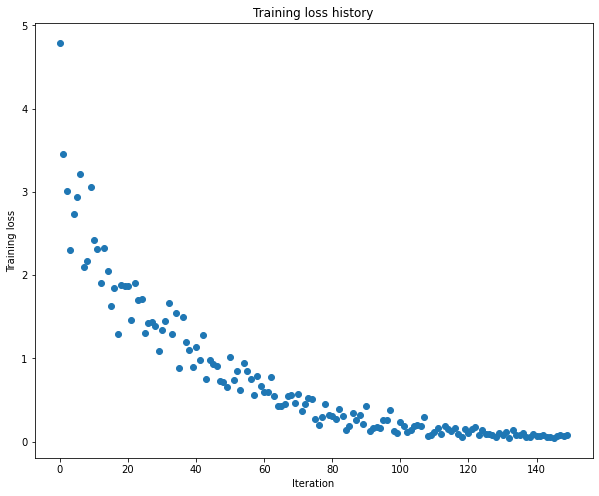

In [ ]:
# TODO: Use a DeepConvNet to overfit 50 training examples by 
# tweaking just the learning rate and initialization scale.
fix_random_seed(0)

num_train = 50
small_data = {
  'X_train': data_dict['X_train'][:num_train],
  'y_train': data_dict['y_train'][:num_train],
  'X_val': data_dict['X_val'],
  'y_val': data_dict['y_val'],
}
input_dims = small_data['X_train'].shape[1:]

weight_scale = 2e-3   # Experiment with this!
learning_rate = 1e-5  # Experiment with this!
############################################################################
# TODO: Change weight_scale and learning_rate so your model achieves 100%  #
# training accuracy within 30 epochs.                                      #
############################################################################
# Replace "pass" statement with your code
weight_scale = 1.869016e-01     # Experiment with this!
learning_rate = 7.972034e-04  # Experiment with this!
# learning_rate 1.135430e-02 weight_scale 3.649494e-02 
# learning_rate 7.972034e-04 weight_scale 1.869016e-01 

# def generate_random_hyperparams(lr_min, lr_max, reg_min, reg_max, h_min, h_max):
#   lr = 10**torch.FloatTensor((1,)).uniform_(lr_min, lr_max)
#   reg = 10**torch.FloatTensor((1,)).uniform_(reg_min,reg_max)
#   hidden = torch.randint(h_min, h_max,(1,))
#   return lr, reg, hidden


# for i in range(30):
#   learning_rate, weight_scale, _ = generate_random_hyperparams(-6,0, -6, 0, 80, 200)
#   learning_rate, weight_scale = torch.tensor(learning_rate).cuda(), torch.tensor(weight_scale).cuda()
#   learning_rate = torch.tensor(learning_rate).cuda()
#   print('learning_rate %e weight_scale %e ' % (learning_rate, weight_scale))
  
#   model = DeepConvNet(input_dims=input_dims, num_classes=10,
#                   num_filters=[8, 16, 32, 64],
#                   max_pools=[0, 1, 2, 3],
#                   reg=1e-5, weight_scale=weight_scale, **to_float_cuda)
#   solver = Solver(model, small_data,
#                   print_every=10, num_epochs=30, batch_size=10,
#                   update_rule=adam,
#                   optim_config={
#                     'learning_rate': learning_rate,
#                   },
#                   device='cuda',
#                   verbose=False
#           )
#   solver.train()
#   print("loss: ",torch.mean(torch.tensor(solver.loss_history[20:])))

############################################################################
#                             END OF YOUR CODE                             #
############################################################################
model = DeepConvNet(input_dims=input_dims, num_classes=10,
                    num_filters=[8, 16, 32, 64],
                    max_pools=[0, 1, 2, 3],
                    reg=1e-5, weight_scale=weight_scale, **to_float_cuda)
solver = Solver(model, small_data,
                print_every=10, num_epochs=30, batch_size=10,
                update_rule=adam,
                optim_config={
                  'learning_rate': learning_rate,
                },
                device='cuda',
         )
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

# Kaiming initialization
So far, you manually tuned the weight scale and for weight initialization.
However, this is inefficient when it comes to training deep neural networks; practically, as your weight matrix is larger, the weight scale should be small.
Below you will implement [Kaiming initialization](http://arxiv-web3.library.cornell.edu/abs/1502.01852). For more details, refer to [cs231n note](http://cs231n.github.io/neural-networks-2/#init) and [PyTorch documentation](https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.kaiming_normal_).

In [24]:
def kaiming_initializer(Din, Dout, K=None, relu=True, device='cpu',
                        dtype=torch.float32):
  """
  Implement Kaiming initialization for linear and convolution layers.
  
  Inputs:
  - Din, Dout: Integers giving the number of input and output dimensions for
    this layer
  - K: If K is None, then initialize weights for a linear layer with Din input
    dimensions and Dout output dimensions. Otherwise if K is a nonnegative
    integer then initialize the weights for a convolution layer with Din input
    channels, Dout output channels, and a kernel size of KxK.
  - relu: If ReLU=True, then initialize weights with a gain of 2 to account for
    a ReLU nonlinearity (Kaiming initializaiton); otherwise initialize weights
    with a gain of 1 (Xavier initialization).
  - device, dtype: The device and datatype for the output tensor.

  Returns:
  - weight: A torch Tensor giving initialized weights for this layer. For a
    linear layer it should have shape (Din, Dout); for a convolution layer it
    should have shape (Dout, Din, K, K).
  """
  gain = 2. if relu else 1.
  weight = None
  if K is None:
    ###########################################################################
    # TODO: Implement Kaiming initialization for linear layer.                #
    # The weight scale is sqrt(gain / fan_in),                                #
    # where gain is 2 if ReLU is followed by the layer, or 1 if not,          #
    # and fan_in = num_in_channels (= Din).                                   #
    # The output should be a tensor in the designated size, dtype, and device.#
    ###########################################################################
    # Replace "pass" statement with your code\
    fan_in = Din
    weight_scale = torch.sqrt(torch.tensor(gain/fan_in).cuda())
    weight = weight_scale*torch.randn((Din, Dout)).to(device).to(dtype)

    ###########################################################################
    #                            END OF YOUR CODE                             #
    ###########################################################################
  else:
    ###########################################################################
    # TODO: Implement Kaiming initialization for convolutional layer.         #
    # The weight scale is sqrt(gain / fan_in),                                #
    # where gain is 2 if ReLU is followed by the layer, or 1 if not,          #
    # and fan_in = num_in_channels (= Din) * K * K                            #
    # The output should be a tensor in the designated size, dtype, and device.#
    ###########################################################################
    # Replace "pass" statement with your code
    # torch.tensor(gain/(Din*K*K)).cuda()
    weight_scale = torch.sqrt(torch.tensor(gain/(Din*K*K)).cuda())
    weight = weight_scale*torch.randn((Dout, Din,K,K)).to(device).to(dtype)
    ###########################################################################
    #                            END OF YOUR CODE                             #
    ###########################################################################
  return weight    

# Convolutional nets with Kaiming initialization
Now that you have a working implementation for Kaiming initialization, go back to your [`DeepConvnet`](#scrollTo=Ah-_nwx2BSxl). Modify your implementation to add Kaiming initialization.

Concretely, when the `weight_scale` is set to `'kaiming'` in the constructor, you should initialize weights of convolutional and linear layers using `kaiming_initializer`. Once you are done, run the following to see the effect of kaiming initialization in deep CNNs.

In this experiment, we train a 31-layer network with four different weight initialization schemes. Among them, only the Kaiming initialization method should achieve a non-random accuracy after one epoch of training.

You may see `nan` loss when `weight_scale` is large, this shows a catastrophe of inappropriate weight initialization.

In [ ]:
fix_random_seed(0)

# Try training a deep convolutional net with different weight initialization methods
num_train = 10000
small_data = {
  'X_train': data_dict['X_train'][:num_train],
  'y_train': data_dict['y_train'][:num_train],
  'X_val': data_dict['X_val'],
  'y_val': data_dict['y_val'],
}
input_dims = data_dict['X_train'].shape[1:]

weight_scales = ['kaiming', 1e-1, 1e-2, 1e-3]

solvers = []
for weight_scale in weight_scales:
  print('Solver with weight scale: ', weight_scale)
  model = DeepConvNet(input_dims=input_dims, num_classes=10,
                      num_filters=([8] * 10) + ([32] * 10) + ([128] * 10),
                      max_pools=[9, 19],
                      weight_scale=weight_scale,
                      reg=1e-5, **to_float_cuda)

  solver = Solver(model, small_data,
                  num_epochs=1, batch_size=128,
                  update_rule=sgd_momentum,
                  optim_config={
                    'learning_rate': 2e-3,
                  },
                  print_every=20, device='cuda')
  solver.train()
  solvers.append(solver)

Solver with weight scale:  kaiming
(Time 0.10 sec; Iteration 1 / 78) loss: 2.331456


/tmp/tmpdp936zzg.ipynb:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


(Epoch 0 / 1) train acc: 0.101000; val_acc: 0.096800
(Time 2.53 sec; Iteration 21 / 78) loss: 2.337187
(Time 3.81 sec; Iteration 41 / 78) loss: 2.323551
(Time 5.10 sec; Iteration 61 / 78) loss: 2.304907
(Epoch 1 / 1) train acc: 0.178000; val_acc: 0.160400
Solver with weight scale:  0.1
(Time 0.06 sec; Iteration 1 / 78) loss: 88.305862
(Epoch 0 / 1) train acc: 0.098000; val_acc: 0.103200
(Time 2.36 sec; Iteration 21 / 78) loss: nan
(Time 3.65 sec; Iteration 41 / 78) loss: nan
(Time 4.93 sec; Iteration 61 / 78) loss: nan
(Epoch 1 / 1) train acc: 0.094000; val_acc: 0.100800
Solver with weight scale:  0.01
(Time 0.06 sec; Iteration 1 / 78) loss: 2.304121
(Epoch 0 / 1) train acc: 0.105000; val_acc: 0.093600
(Time 2.37 sec; Iteration 21 / 78) loss: 2.304212
(Time 3.67 sec; Iteration 41 / 78) loss: 2.304447
(Time 4.95 sec; Iteration 61 / 78) loss: 2.305000
(Epoch 1 / 1) train acc: 0.115000; val_acc: 0.093600
Solver with weight scale:  0.001
(Time 0.06 sec; Iteration 1 / 78) loss: 2.302599
(Ep

In [ ]:
def plot_training_history_init(title, xlabel, solvers, labels, plot_fn, marker='-o'):
  plt.title(title)
  plt.xlabel(xlabel)
  for solver, label in zip(solvers, labels):    
    data = plot_fn(solver)
    label = 'weight_scale=' + str(label)
    plt.plot(data, marker, label=label)
  plt.legend(loc='lower center', ncol=len(solvers))

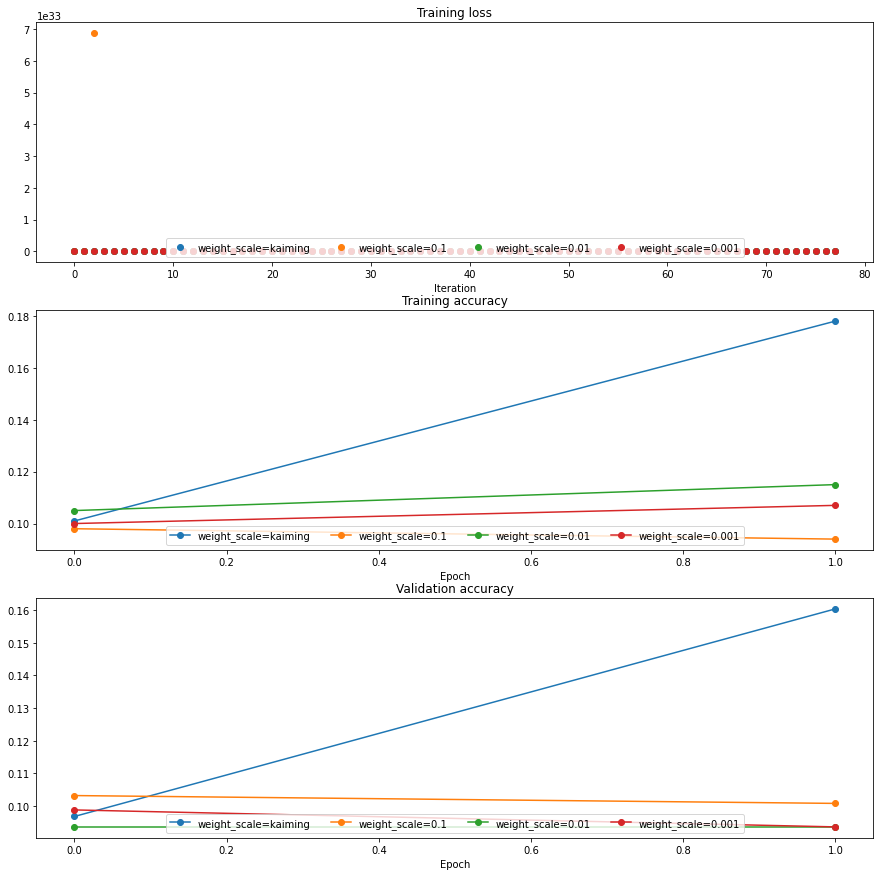

In [ ]:
plt.subplot(3, 1, 1)
plot_training_history_init('Training loss','Iteration', solvers, weight_scales,
                            lambda x: x.loss_history, marker='o')
plt.subplot(3, 1, 2)
plot_training_history_init('Training accuracy','Epoch', solvers, weight_scales,
                           lambda x: x.train_acc_history)
plt.subplot(3, 1, 3)
plot_training_history_init('Validation accuracy','Epoch', solvers, weight_scales,
                           lambda x: x.val_acc_history)
plt.gcf().set_size_inches(15, 15)
plt.show()

# Train a good model!
Train the best convolutional model that you can on CIFAR-10, storing your best model in the `best_model` variable. We require you to get at least 72% accuracy on the validation set using a convolutional net, within 60 seconds of training.

You might find it useful to use batch normalization in your model. However, since we do not ask you to implement it CUDA-friendly, it might slow down training.

Hint: Your model does not have to be too deep.

Hint 2: We used `batch_size = 128` for training a model with 76% validation accuracy. You don't have to follow this, but it would save your time for hyperparameter search.

In [ ]:
input_dims = data_dict['X_train'].shape[1:]
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

weight_scale = 1.869016e-01     # Experiment with this!
# learning_rate = 7.972034e-04  # Experiment with this!
learning_rate = 8.607833e-04 
model = None
solver = None


# def generate_random_hyperparams(lr_min, lr_max, reg_min, reg_max, h_min, h_max):
#   lr = 10**torch.FloatTensor((1,)).uniform_(lr_min, lr_max)
#   # reg = 10**torch.FloatTensor((1,)).uniform_(reg_min,reg_max)
#   # hidden = torch.randint(h_min, h_max,(1,))
#   return lr#, reg, hidden


# for i in range(30):
#   learning_rate = generate_random_hyperparams(-4,-2, -6, 0, 80, 200)
#   learning_rate = torch.tensor(learning_rate).cuda()
#   print('learning_rate %e ' % (learning_rate))
  
#   model = DeepConvNet(input_dims=input_dims, num_classes=10,
#                   num_filters=[64,64,128,128,256],
#                   max_pools=[1,3,4],
#                   reg=1e-5, weight_scale='kaiming', **to_float_cuda)
#   solver = Solver(model, small_data,
#                   print_every=10, num_epochs=5, batch_size=128,
#                   update_rule=adam,
#                   optim_config={
#                     'learning_rate': learning_rate,
#                   },
#                   device='cuda',
#                   verbose=False
#           )
#   solver.train()
#   print("loss: ",torch.mean(torch.tensor(solver.loss_history[20:])))

################################################################################
# TODO: Train the best DeepConvNet that you can on CIFAR-10 within 60 seconds. #
################################################################################
# Replace "pass" statement with your code
model = DeepConvNet(input_dims=input_dims, num_classes=10,
                    num_filters=[64,64,128,128,256],
                    max_pools=[1,3,4],
                    reg=1e-5, weight_scale='kaiming', **to_float_cuda)
solver = Solver(model, data_dict,
                print_every=10, num_epochs=5, batch_size=128,
                update_rule=adam,
                optim_config={
                  'learning_rate': learning_rate,
                },
                device='cuda',
         )
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
solver.train(time_limit=60)

torch.backends.cudnn.benchmark = False

/tmp/tmpdp936zzg.ipynb:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


(Time 0.30 sec; Iteration 1 / 1855) loss: 2.384609
(Epoch 0 / 5) train acc: 0.115000; val_acc: 0.111200
(Time 1.02 sec; Iteration 11 / 1855) loss: 2.131680
(Time 1.32 sec; Iteration 21 / 1855) loss: 2.045117
(Time 1.63 sec; Iteration 31 / 1855) loss: 1.838403
(Time 1.93 sec; Iteration 41 / 1855) loss: 1.848189
(Time 2.24 sec; Iteration 51 / 1855) loss: 1.801888
(Time 2.54 sec; Iteration 61 / 1855) loss: 1.578771
(Time 2.86 sec; Iteration 71 / 1855) loss: 1.623603
(Time 3.16 sec; Iteration 81 / 1855) loss: 1.586812
(Time 3.47 sec; Iteration 91 / 1855) loss: 1.533550
(Time 3.78 sec; Iteration 101 / 1855) loss: 1.415161
(Time 4.08 sec; Iteration 111 / 1855) loss: 1.441251
(Time 4.39 sec; Iteration 121 / 1855) loss: 1.381840
(Time 4.70 sec; Iteration 131 / 1855) loss: 1.421576
(Time 5.00 sec; Iteration 141 / 1855) loss: 1.382020
(Time 5.31 sec; Iteration 151 / 1855) loss: 1.289174
(Time 5.61 sec; Iteration 161 / 1855) loss: 1.364742
(Time 5.91 sec; Iteration 171 / 1855) loss: 1.313222
(Tim

# Test your model!
Run your best model on the validation and test sets. You should achieve above 72% accuracy on the validation set and 70% accuracy on the test set.

(Our best model gets 76% validation accuracy and 75% test accuracy -- can you beat ours?)


In [ ]:
print('Validation set accuracy: ', solver.check_accuracy(data_dict['X_val'], data_dict['y_val']))
print('Test set accuracy: ', solver.check_accuracy(data_dict['X_test'], data_dict['y_test']))

Validation set accuracy:  0.7735999822616577
Test set accuracy:  0.7714999914169312


# Batch Normalization
One way to make deep networks easier to train is to use more sophisticated optimization procedures such as SGD+momentum, RMSProp, or Adam. Another strategy is to change the architecture of the network to make it easier to train. 
One idea along these lines is batch normalization which was proposed by [1] in 2015.

The idea is relatively straightforward. Machine learning methods tend to work better when their input data consists of uncorrelated features with zero mean and unit variance. When training a neural network, we can preprocess the data before feeding it to the network to explicitly decorrelate its features; this will ensure that the first layer of the network sees data that follows a nice distribution. However, even if we preprocess the input data, the activations at deeper layers of the network will likely no longer be decorrelated and will no longer have zero mean or unit variance since they are output from earlier layers in the network. Even worse, during the training process the distribution of features at each layer of the network will shift as the weights of each layer are updated.

The authors of [1] hypothesize that the shifting distribution of features inside deep neural networks may make training deep networks more difficult. To overcome this problem, [1] proposes to insert batch normalization layers into the network. At training time, a batch normalization layer uses a minibatch of data to estimate the mean and standard deviation of each feature. These estimated means and standard deviations are then used to center and normalize the features of the minibatch. A running average of these means and standard deviations is kept during training, and at test time these running averages are used to center and normalize features.

It is possible that this normalization strategy could reduce the representational power of the network, since it may sometimes be optimal for certain layers to have features that are not zero-mean or unit variance. To this end, the batch normalization layer includes learnable shift and scale parameters for each feature dimension.

[1] [Sergey Ioffe and Christian Szegedy, "Batch Normalization: Accelerating Deep Network Training by Reducing
Internal Covariate Shift", ICML 2015.](https://arxiv.org/abs/1502.03167)

In [25]:
class BatchNorm(object):

  @staticmethod
  def forward(x, gamma, beta, bn_param):
    raise NotImplementedError

  @staticmethod
  def backward(dout, cache):
    raise NotImplementedError

  @staticmethod
  def backward_alt(dout, cache):
    raise NotImplementedError

## Batch normalization: forward
Implement the batch normalization forward pass in the function `BatchNorm.forward`. Once you have done so, run the following to test your implementation.

Referencing the paper linked to above in [1] may be helpful!

In [26]:
def batchnorm_forward(x, gamma, beta, bn_param):
  """
  Forward pass for batch normalization.

  During training the sample mean and (uncorrected) sample variance are
  computed from minibatch statistics and used to normalize the incoming data.
  During training we also keep an exponentially decaying running mean of the
  mean and variance of each feature, and these averages are used to normalize
  data at test-time.

  At each timestep we update the running averages for mean and variance using
  an exponential decay based on the momentum parameter:

  running_mean = momentum * running_mean + (1 - momentum) * sample_mean
  running_var = momentum * running_var + (1 - momentum) * sample_var

  Note that the batch normalization paper suggests a different test-time
  behavior: they compute sample mean and variance for each feature using a
  large number of training images rather than using a running average. For
  this implementation we have chosen to use running averages instead since
  they do not require an additional estimation step; the PyTorch
  implementation of batch normalization also uses running averages.

  Input:
  - x: Data of shape (N, D)
  - gamma: Scale parameter of shape (D,)
  - beta: Shift paremeter of shape (D,)
  - bn_param: Dictionary with the following keys:
    - mode: 'train' or 'test'; required
    - eps: Constant for numeric stability
    - momentum: Constant for running mean / variance.
    - running_mean: Array of shape (D,) giving running mean of features
    - running_var Array of shape (D,) giving running variance of features

  Returns a tuple of:
  - out: of shape (N, D)
  - cache: A tuple of values needed in the backward pass
  """
  mode = bn_param['mode']
  eps = bn_param.get('eps', 1e-5)
  momentum = bn_param.get('momentum', 0.9)

  N, D = x.shape
  running_mean = bn_param.get('running_mean', torch.zeros(D, dtype=x.dtype, device=x.device))
  running_var = bn_param.get('running_var', torch.zeros(D, dtype=x.dtype, device=x.device))

  out, cache = None, None
  if mode == 'train':
    #######################################################################
    # TODO: Implement the training-time forward pass for batch norm.      #
    # Use minibatch statistics to compute the mean and variance, use      #
    # these statistics to normalize the incoming data, and scale and      #
    # shift the normalized data using gamma and beta.                     #
    #                                                                     #
    # You should store the output in the variable out. Any intermediates  #
    # that you need for the backward pass should be stored in the cache   #
    # variable.                                                           #
    #                                                                     #
    # You should also use your computed sample mean and variance together #
    # with the momentum variable to update the running mean and running   #
    # variance, storing your result in the running_mean and running_var   #
    # variables.                                                          #
    #                                                                     #
    # Note that though you should be keeping track of the running         #
    # variance, you should normalize the data based on the standard       #
    # deviation (square root of variance) instead!                        # 
    # Referencing the original paper (https://arxiv.org/abs/1502.03167)   #
    # might prove to be helpful.                                          #
    #######################################################################
    # Replace "pass" statement with your code
    sample_mean = torch.mean(x,0)
    sample_var = torch.sum((x-sample_mean)**2,axis=0)/N
    # sample_var = torch.var(x,0)
    x_hat = (x-sample_mean)/(torch.sqrt(sample_var+eps))
    y = gamma*x_hat + beta
    out = y

    running_mean = momentum * running_mean + (1 - momentum) * sample_mean
    running_var = momentum * running_var + (1 - momentum) * sample_var

    cache = (x_hat, x, sample_mean, sample_var,out,running_mean,running_var,momentum,eps,gamma,beta)
    #######################################################################
    #                           END OF YOUR CODE                          #
    #######################################################################
  elif mode == 'test':
    #######################################################################
    # TODO: Implement the test-time forward pass for batch normalization. #
    # Use the running mean and variance to normalize the incoming data,   #
    # then scale and shift the normalized data using gamma and beta.      #
    # Store the result in the out variable.                               #
    #######################################################################
    # Replace "pass" statement with your code
    x_hat = (x-running_mean)/(torch.sqrt(running_var+eps))
    y = gamma*x_hat + beta
    out = y
    #######################################################################
    #                           END OF YOUR CODE                          #
    #######################################################################
  else:
    raise ValueError('Invalid forward batchnorm mode "%s"' % mode)

  # Store the updated running means back into bn_param
  bn_param['running_mean'] = running_mean.detach()
  bn_param['running_var'] = running_var.detach()

  return out, cache

BatchNorm.forward = batchnorm_forward

After implementing the forward pass for batch normalization, you can run the following to sanity check your implementation. After running batch normalization with beta=0 and gamma=1, the data should have zero mean and unit variance.

After running batch normalization with nontrivial beta and gamma, the output data should have mean approximately equal to beta, and std approximatly equal to gamma.

In [28]:
# Check the training-time forward pass by checking means and variances
# of features both before and after batch normalization   
def print_mean_std(x,dim=0):
  means = ['%.3f' % xx for xx in x.mean(dim=dim).tolist()]
  stds = ['%.3f' % xx for xx in x.std(dim=dim).tolist()]
  print('  means: ', means)
  print('  stds:  ', stds)
  print()

# Simulate the forward pass for a two-layer network
reset_seed(0)
N, D1, D2, D3 = 200, 50, 60, 3
X = torch.randn(N, D1, **to_double_cuda)
W1 = torch.randn(D1, D2, **to_double_cuda)
W2 = torch.randn(D2, D3, **to_double_cuda)
a = X.matmul(W1).clamp(min=0.).matmul(W2)

print('Before batch normalization:')
print_mean_std(a,dim=0)

# Run with gamma=1, beta=0. Means should be close to zero and stds close to one
gamma = torch.ones(D3, **to_double_cuda)
beta = torch.zeros(D3, **to_double_cuda)
print('After batch normalization (gamma=1, beta=0)')
a_norm, _ = BatchNorm.forward(a, gamma, beta, {'mode': 'train'})
print_mean_std(a_norm,dim=0)

# Run again with nontrivial gamma and beta. Now means should be close to beta
# and std should be close to gamma.
gamma = torch.tensor([1.0, 2.0, 3.0], **to_double_cuda)
beta = torch.tensor([11.0, 12.0, 13.0], **to_double_cuda)
print('After batch normalization (gamma=', gamma.tolist(), ', beta=', beta.tolist(), ')')
a_norm, _ = BatchNorm.forward(a, gamma, beta, {'mode': 'train'})
print_mean_std(a_norm,dim=0)

Before batch normalization:
  means:  ['52.046', '11.122', '10.243']
  stds:   ['34.646', '30.732', '39.429']

After batch normalization (gamma=1, beta=0)
  means:  ['0.000', '0.000', '0.000']
  stds:   ['1.003', '1.003', '1.003']

After batch normalization (gamma= [1.0, 2.0, 3.0] , beta= [11.0, 12.0, 13.0] )
  means:  ['11.000', '12.000', '13.000']
  stds:   ['1.003', '2.005', '3.008']



We can sanity-check the test-time forward pass of batch normalization by running the following. First we run the training-time forward pass many times to "warm up" the running averages. If we then run a test-time forward pass, the output should have approximately zero mean and unit variance.

In [29]:
reset_seed(0)
N, D1, D2, D3 = 200, 50, 60, 3
W1 = torch.randn(D1, D2, **to_double_cuda)
W2 = torch.randn(D2, D3, **to_double_cuda)

bn_param = {'mode': 'train'}
gamma = torch.ones(D3, **to_double_cuda)
beta = torch.zeros(D3, **to_double_cuda)

for t in range(500):
  X = torch.randn(N, D1, **to_double_cuda)
  a = X.matmul(W1).clamp(min=0.).matmul(W2)
  BatchNorm.forward(a, gamma, beta, bn_param)

bn_param['mode'] = 'test'
X = torch.randn(N, D1, **to_double_cuda)
a = X.matmul(W1).clamp(min=0.).matmul(W2)
a_norm, _ = BatchNorm.forward(a, gamma, beta, bn_param)

# Means should be close to zero and stds close to one, but will be
# noisier than training-time forward passes.
print('After batch normalization (test-time):')
print_mean_std(a_norm,dim=0)

After batch normalization (test-time):
  means:  ['0.031', '-0.051', '0.061']
  stds:   ['1.011', '0.958', '1.068']



## Batch normalization: backward
Now implement the backward pass for batch normalization in the function `BatchNorm.backward`.

To derive the backward pass you should write out the computation graph for batch normalization and backprop through each of the intermediate nodes. Some intermediates may have multiple outgoing branches; make sure to sum gradients across these branches in the backward pass.

Please don't forget to implement the train and test mode separately.

Once you have finished, run the following to numerically check your backward pass.

In [30]:
def batchnorm_backward(dout, cache):
  """
  Backward pass for batch normalization.

  For this implementation, you should write out a computation graph for
  batch normalization on paper and propagate gradients backward through
  intermediate nodes.

  Inputs:
  - dout: Upstream derivatives, of shape (N, D)
  - cache: Variable of intermediates from batchnorm_forward.

  Returns a tuple of:
  - dx: Gradient with respect to inputs x, of shape (N, D)
  - dgamma: Gradient with respect to scale parameter gamma, of shape (D,)
  - dbeta: Gradient with respect to shift parameter beta, of shape (D,)
  """
  dx, dgamma, dbeta = None, None, None
  ###########################################################################
  # TODO: Implement the backward pass for batch normalization. Store the    #
  # results in the dx, dgamma, and dbeta variables.                         #
  # Referencing the original paper (https://arxiv.org/abs/1502.03167)       #
  # might prove to be helpful.                                              #
  # Don't forget to implement train and test mode separately.               #
  ###########################################################################
  # Replace "pass" statement with your code
  N,D = dout.shape
  x_hat, x, sample_mean, sample_var,out, running_mean,running_var,momentum,eps,gamma,beta = cache
  dxhat= dout*gamma
  dgamma= torch.sum(dout*x_hat,0)
  dbeta = torch.sum(dout,0)

  dvariance = torch.sum(dxhat*(x-sample_mean),0)*-0.5*((sample_var+eps)**(-3/2))

  dmu = (torch.sum(dxhat,0)*(-1)/((sample_var+eps)**0.5)) + dvariance* torch.ones((N, D)).to(x.dtype).to(x.device)*torch.sum(-2*(x-sample_mean),0)/N
  dx = dxhat/((sample_var+eps)**0.5) + dvariance*2*(x-sample_mean)/N + dmu* torch.ones((N, D)).to(x.dtype).to(x.device)/N

  ###########################################################################
  #                             END OF YOUR CODE                            #
  ###########################################################################

  return dx, dgamma, dbeta

BatchNorm.backward = batchnorm_backward

In [32]:
# Gradient check batchnorm backward pass
reset_seed(0)
N, D = 4, 5
x = 5 * torch.randn(N, D, **to_double_cuda) + 12
gamma = torch.randn(D, **to_double_cuda)
beta = torch.randn(D, **to_double_cuda)
dout = torch.randn(N, D, **to_double_cuda)

bn_param = {'mode': 'train'}
fx = lambda x: BatchNorm.forward(x, gamma, beta, bn_param)[0]
fg = lambda a: BatchNorm.forward(x, a, beta, bn_param)[0]
fb = lambda b: BatchNorm.forward(x, gamma, b, bn_param)[0]

dx_num = eecs598.grad.compute_numeric_gradient(fx, x, dout)
da_num = eecs598.grad.compute_numeric_gradient(fg, gamma.clone(), dout)
db_num = eecs598.grad.compute_numeric_gradient(fb, beta.clone(), dout)

_, cache = BatchNorm.forward(x, gamma, beta, bn_param)
dx, dgamma, dbeta = BatchNorm.backward(dout, cache)
# You should expect to see relative errors between 1e-12 and 1e-9
print('dx error: ', eecs598.grad.rel_error(dx_num, dx))
print('dgamma error: ', eecs598.grad.rel_error(da_num, dgamma))
print('dbeta error: ', eecs598.grad.rel_error(db_num, dbeta))

dx error:  9.592374251767864e-09
dgamma error:  2.3926175251513886e-10
dbeta error:  2.919336030277982e-10


## Batch normalization: alternative backward
In class we talked about two different implementations for the sigmoid backward pass. One strategy is to write out a computation graph composed of simple operations and backprop through all intermediate values. Another strategy is to work out the derivatives on paper. For example, you can derive a very simple formula for the sigmoid function's backward pass by simplifying gradients on paper.

Surprisingly, it turns out that you can do a similar simplification for the batch normalization backward pass too!  

In the forward pass, given a set of inputs $X=\begin{bmatrix}x_1\\x_2\\...\\x_N\end{bmatrix}$, 

we first calculate the mean $\mu$ and variance $v$.
With $\mu$ and $v$ calculated, we can calculate the standard deviation $\sigma$  and normalized data $Y$.
The equations and graph illustration below describe the computation ($y_i$ is the i-th element of the vector $Y$).

\begin{align}
& \mu=\frac{1}{N}\sum_{k=1}^N x_k  &  v=\frac{1}{N}\sum_{k=1}^N (x_k-\mu)^2 \\
& \sigma=\sqrt{v+\epsilon}         &  y_i=\frac{x_i-\mu}{\sigma}
\end{align}

<img src="https://web.eecs.umich.edu/~justincj/teaching/eecs498/assets/a3/batchnorm_graph.png" width=691 height=202>

The meat of our problem during backpropagation is to compute $\frac{\partial L}{\partial X}$, given the upstream gradient we receive, $\frac{\partial L}{\partial Y}.$ To do this, recall the chain rule in calculus gives us $\frac{\partial L}{\partial X} = \frac{\partial L}{\partial Y} \cdot \frac{\partial Y}{\partial X}$.

The unknown/hart part is $\frac{\partial Y}{\partial X}$. We can find this by first deriving step-by-step our local gradients at 
$\frac{\partial v}{\partial X}$, $\frac{\partial \mu}{\partial X}$,
$\frac{\partial \sigma}{\partial v}$, 
$\frac{\partial Y}{\partial \sigma}$, and $\frac{\partial Y}{\partial \mu}$,
and then use the chain rule to compose these gradients (which appear in the form of vectors!) appropriately to compute $\frac{\partial Y}{\partial X}$.

If it's challenging to directly reason about the gradients over $X$ and $Y$ which require matrix multiplication, try reasoning about the gradients in terms of individual elements $x_i$ and $y_i$ first: in that case, you will need to come up with the derivations for $\frac{\partial L}{\partial x_i}$, by relying on the Chain Rule to first calculate the intermediate $\frac{\partial \mu}{\partial x_i}, \frac{\partial v}{\partial x_i}, \frac{\partial \sigma}{\partial x_i},$ then assemble these pieces to calculate $\frac{\partial y_i}{\partial x_i}$. 

You should make sure each of the intermediary gradient derivations are all as simplified as possible, for ease of implementation. 

After doing so, implement the simplified batch normalization backward pass in the function `BatchNorm.backward_alt` and compare the two implementations by running the following. Your two implementations should compute nearly identical results, but the alternative implementation should be a bit faster.

In [33]:
def batchnorm_backward_alt(dout, cache):
  """
  Alternative backward pass for batch normalization.
  For this implementation you should work out the derivatives for the batch
  normalizaton backward pass on paper and simplify as much as possible. You
  should be able to derive a simple expression for the backward pass. 
  See the jupyter notebook for more hints.
   
  Note: This implementation should expect to receive the same cache variable
  as batchnorm_backward, but might not use all of the values in the cache.

  Inputs / outputs: Same as batchnorm_backward
  """
  dx, dgamma, dbeta = None, None, None
  ###########################################################################
  # TODO: Implement the backward pass for batch normalization. Store the    #
  # results in the dx, dgamma, and dbeta variables.                         #
  #                                                                         #
  # After computing the gradient with respect to the centered inputs, you   #
  # should be able to compute gradients with respect to the inputs in a     #
  # single statement; our implementation fits on a single 80-character line.#
  ###########################################################################
  # Replace "pass" statement with your code
  N,D = dout.shape
  x_hat, x, sample_mean, sample_var,out, running_mean,running_var,momentum,eps,gamma,beta = cache
  dxhat= dout*gamma
  dgamma= torch.sum(dout*x_hat,0)
  dbeta = torch.sum(dout,0)

  dx = (dout * gamma - (dout * gamma).sum(0)/N - (dout * gamma * x_hat).sum(0) * x_hat/N)/sample_var**(1/2)
  # dfdz = dout * gamma                                    #[NxD]
  # dfdz_sum = dfdz.sum(0)                                  #[1xD]
  # dx = dfdz - dfdz_sum/dout.shape[0] - (dfdz * x_hat).sum(0) * x_hat/dout.shape[0]          #[NxD]
  # dx /= var**(1/2)
  
  ###########################################################################
  #                             END OF YOUR CODE                            #
  ###########################################################################

  return dx, dgamma, dbeta

BatchNorm.backward_alt = batchnorm_backward_alt

In [35]:
reset_seed(0)
N, D = 128, 2048
x = 5 * torch.randn(N, D, **to_double_cuda) + 12
gamma = torch.randn(D, **to_double_cuda)
beta = torch.randn(D, **to_double_cuda)
dout = torch.randn(N, D, **to_double_cuda)

bn_param = {'mode': 'train'}
out, cache = BatchNorm.forward(x, gamma, beta, bn_param)

t1 = time.time()
dx1, dgamma1, dbeta1 = BatchNorm.backward(dout, cache)
t2 = time.time()
dx2, dgamma2, dbeta2 = BatchNorm.backward_alt(dout, cache)
t3 = time.time()

print('dx difference: ', eecs598.grad.rel_error(dx1, dx2))
print('dgamma difference: ', eecs598.grad.rel_error(dgamma1, dgamma2))
print('dbeta difference: ', eecs598.grad.rel_error(dbeta1, dbeta2))
print('speedup: %.2fx' % ((t2 - t1) / (t3 - t2)))

dx difference:  1.1579114262453234e-07
dgamma difference:  0.0
dbeta difference:  0.0
speedup: 10.98x


# Spatial Batch Normalization
As proposed in the original paper, batch normalization can also be used for convolutional networks, but we need to tweak it a bit; the modification will be called "spatial batch normalization."

Normally batch-normalization accepts inputs of shape `(N, D)` and produces outputs of shape `(N, D)`, where we normalize across the minibatch dimension `N`. For data coming from convolutional layers, batch normalization needs to accept inputs of shape `(N, C, H, W)` and produce outputs of shape `(N, C, H, W)` where the `N` dimension gives the minibatch size and the `(H, W)` dimensions give the spatial size of the feature map.

If the feature map was produced using convolutions, then we expect every feature channel's statistics e.g. mean, variance to be relatively consistent both between different images, and different locations within the same image -- after all, every feature channel is produced by the same convolutional filter! Therefore spatial batch normalization computes a mean and variance for each of the `C` feature channels by computing statistics over the minibatch dimension `N` as well the spatial dimensions `H` and `W`.


[1] [Sergey Ioffe and Christian Szegedy, "Batch Normalization: Accelerating Deep Network Training by Reducing
Internal Covariate Shift", ICML 2015.](https://arxiv.org/abs/1502.03167)

In [36]:
class SpatialBatchNorm(object):

  @staticmethod
  def forward(x, gamma, beta, bn_param):
    raise NotImplementedError

  @staticmethod
  def backward(dout, cache):
    raise NotImplementedError

## Spatial batch normalization: forward

Implement the forward pass for spatial batch normalization in the function `SpatialBatchNorm.forward`. Check your implementation by running the following:

In [37]:
def spatial_batchnorm_forward(x, gamma, beta, bn_param):
  """
  Computes the forward pass for spatial batch normalization.

  Inputs:
  - x: Input data of shape (N, C, H, W)
  - gamma: Scale parameter, of shape (C,)
  - beta: Shift parameter, of shape (C,)
  - bn_param: Dictionary with the following keys:
    - mode: 'train' or 'test'; required
    - eps: Constant for numeric stability
    - momentum: Constant for running mean / variance. momentum=0 means that
    old information is discarded completely at every time step, while
    momentum=1 means that new information is never incorporated. The
    default of momentum=0.9 should work well in most situations.
    - running_mean: Array of shape (D,) giving running mean of features
    - running_var Array of shape (D,) giving running variance of features

  Returns a tuple of:
  - out: Output data, of shape (N, C, H, W)
  - cache: Values needed for the backward pass
  """
  out, cache = None, None

  ###########################################################################
  # TODO: Implement the forward pass for spatial batch normalization.       #
  #                                                                         #
  # HINT: You can implement spatial batch normalization by calling the      #
  # vanilla version of batch normalization you implemented above.           #
  # Your implementation should be very short; ours is less than five lines. #
  ###########################################################################
  # Replace "pass" statement with your code
  N,C,H,W = x.shape
  a = x.clone().permute(0,2,3,1).reshape(N*H*W,C)
  out, cache= batchnorm_forward(a, gamma, beta, bn_param)
  out = out.reshape(N,H,W,C).permute(0,3,1,2)
  
  ###########################################################################
  #                             END OF YOUR CODE                            #
  ###########################################################################

  return out, cache

SpatialBatchNorm.forward = spatial_batchnorm_forward

After implementing the forward pass for spatial batch normalization, you can run the following to sanity check your code.

In [38]:
reset_seed(0)
# Check the training-time forward pass by checking means and variances
# of features both before and after spatial batch normalization

N, C, H, W = 2, 3, 4, 5
x = 4 * torch.randn(N, C, H, W, **to_double_cuda) + 10

print('Before spatial batch normalization:')
print('  Shape: ', x.shape)
print('  Means: ', x.mean(dim=(0, 2, 3)))
print('  Stds: ', x.std(dim=(0, 2, 3)))

# Means should be close to zero and stds close to one
gamma, beta = torch.ones(C, **to_double_cuda), torch.zeros(C, **to_double_cuda)
bn_param = {'mode': 'train'}
out, _ = SpatialBatchNorm.forward(x, gamma, beta, bn_param)
print('After spatial batch normalization:')
print('  Shape: ', out.shape)
print('  Means: ', out.mean(dim=(0, 2, 3)))
print('  Stds: ', out.std(dim=(0, 2, 3)))

# Means should be close to beta and stds close to gamma
gamma, beta = torch.tensor([3, 4, 5], **to_double_cuda), torch.tensor([6, 7, 8], **to_double_cuda)
out, _ = SpatialBatchNorm.forward(x, gamma, beta, bn_param)
print('After spatial batch normalization (nontrivial gamma, beta):')
print('  Shape: ', out.shape)
print('  Means: ', out.mean(dim=(0, 2, 3)))
print('  Stds: ', out.std(dim=(0, 2, 3)))

Before spatial batch normalization:
  Shape:  torch.Size([2, 3, 4, 5])
  Means:  tensor([ 9.5501, 10.2173,  9.8379], device='cuda:0', dtype=torch.float64)
  Stds:  tensor([3.9212, 4.7963, 3.6011], device='cuda:0', dtype=torch.float64)
After spatial batch normalization:
  Shape:  torch.Size([2, 3, 4, 5])
  Means:  tensor([-3.6754e-08, -3.2148e-08, -4.1227e-08], device='cuda:0',
       dtype=torch.float64)
  Stds:  tensor([1.0127, 1.0127, 1.0127], device='cuda:0', dtype=torch.float64)
After spatial batch normalization (nontrivial gamma, beta):
  Shape:  torch.Size([2, 3, 4, 5])
  Means:  tensor([6.0000, 7.0000, 8.0000], device='cuda:0', dtype=torch.float64)
  Stds:  tensor([3.0382, 4.0510, 5.0637], device='cuda:0', dtype=torch.float64)


Similar to the vanilla batch normalization implementation, run the following to sanity-check the test-time forward pass of spatial batch normalization.

In [39]:
reset_seed(0)
# Check the test-time forward pass by running the training-time
# forward pass many times to warm up the running averages, and then
# checking the means and variances of activations after a test-time
# forward pass.
N, C, H, W = 10, 4, 11, 12

bn_param = {'mode': 'train'}
gamma = torch.ones(C, **to_double_cuda)
beta = torch.zeros(C, **to_double_cuda)
for t in range(50):
  x = 2.3 * torch.randn(N, C, H, W, **to_double_cuda) + 13
  SpatialBatchNorm.forward(x, gamma, beta, bn_param)
bn_param['mode'] = 'test'
x = 2.3 * torch.randn(N, C, H, W, **to_double_cuda) + 13
a_norm, _ = SpatialBatchNorm.forward(x, gamma, beta, bn_param)

# Means should be close to zero and stds close to one, but will be
# noisier than training-time forward passes.
print('After spatial batch normalization (test-time):')
print('  means: ', a_norm.mean(dim=(0, 2, 3)))
print('  stds: ', a_norm.std(dim=(0, 2, 3)))

After spatial batch normalization (test-time):
  means:  tensor([0.0188, 0.0145, 0.0422, 0.0231], device='cuda:0', dtype=torch.float64)
  stds:  tensor([0.9861, 1.0143, 1.0138, 0.9916], device='cuda:0', dtype=torch.float64)


## Spatial batch normalization: backward
Implement the backward pass for spatial batch normalization in the function `SpatialBatchNorm.backward`.

In [40]:
def spatial_batchnorm_backward(dout, cache):
  """
  Computes the backward pass for spatial batch normalization.
  Inputs:
  - dout: Upstream derivatives, of shape (N, C, H, W)
  - cache: Values from the forward pass
  Returns a tuple of:
  - dx: Gradient with respect to inputs, of shape (N, C, H, W)
  - dgamma: Gradient with respect to scale parameter, of shape (C,)
  - dbeta: Gradient with respect to shift parameter, of shape (C,)
  """
  dx, dgamma, dbeta = None, None, None

  ###########################################################################
  # TODO: Implement the backward pass for spatial batch normalization.      #
  #                                                                         #
  # HINT: You can implement spatial batch normalization by calling the      #
  # vanilla version of batch normalization you implemented above.           #
  # Your implementation should be very short; ours is less than five lines. #
  ###########################################################################
  # Replace "pass" statement with your code
  N,C,H,W = dout.shape
  dout_s = dout.clone().permute(0,2,3,1).reshape(N*H*W,C)
  dx,dgamma,dbeta = batchnorm_backward_alt(dout_s, cache)
  dx = dx.reshape(N,H,W,C).permute(0,3,1,2)
  
  ###########################################################################
  #                             END OF YOUR CODE                            #
  ###########################################################################

  return dx, dgamma, dbeta

SpatialBatchNorm.backward = spatial_batchnorm_backward

After implementing the backward pass for spatial batch normalization, run the following to perform numeric gradient checking on your implementation. You should see errors less than `1e-6`.

In [42]:
reset_seed(0)
N, C, H, W = 2, 3, 4, 5
x = 5 * torch.randn(N, C, H, W, **to_double_cuda) + 12
gamma = torch.randn(C, **to_double_cuda)
beta = torch.randn(C, **to_double_cuda)
dout = torch.randn(N, C, H, W, **to_double_cuda)

bn_param = {'mode': 'train'}
fx = lambda x: SpatialBatchNorm.forward(x, gamma, beta, bn_param)[0]
fg = lambda a: SpatialBatchNorm.forward(x, gamma, beta, bn_param)[0]
fb = lambda b: SpatialBatchNorm.forward(x, gamma, beta, bn_param)[0]

dx_num = eecs598.grad.compute_numeric_gradient(fx, x, dout)
da_num = eecs598.grad.compute_numeric_gradient(fg, gamma, dout)
db_num = eecs598.grad.compute_numeric_gradient(fb, beta, dout)

_, cache = SpatialBatchNorm.forward(x, gamma, beta, bn_param)
dx, dgamma, dbeta = SpatialBatchNorm.backward(dout, cache)
print('dx error: ', eecs598.grad.rel_error(dx_num, dx))
print('dgamma error: ', eecs598.grad.rel_error(da_num, dgamma))
print('dbeta error: ', eecs598.grad.rel_error(db_num, dbeta))

dx error:  1.3063872155008488e-07
dgamma error:  1.3661558088725954e-10
dbeta error:  2.865163731767531e-10


# "Sandwich" layers with batch normalization
Again, below you will find sandwich layers that implement a few commonly used patterns for convolutional networks.

In [43]:
class Linear_BatchNorm_ReLU(object):

  @staticmethod
  def forward(x, w, b, gamma, beta, bn_param):
    """
    Convenience layer that performs an linear transform, batch normalization,
    and ReLU.
    Inputs:
    - x: Array of shape (N, D1); input to the linear layer
    - w, b: Arrays of shape (D2, D2) and (D2,) giving the weight and bias for
      the linear transform.
    - gamma, beta: Arrays of shape (D2,) and (D2,) giving scale and shift
      parameters for batch normalization.
    - bn_param: Dictionary of parameters for batch normalization.
    Returns:
    - out: Output from ReLU, of shape (N, D2)
    - cache: Object to give to the backward pass.
    """
    a, fc_cache = Linear.forward(x, w, b)
    a_bn, bn_cache = BatchNorm.forward(a, gamma, beta, bn_param)
    out, relu_cache = ReLU.forward(a_bn)
    cache = (fc_cache, bn_cache, relu_cache)
    return out, cache

  @staticmethod
  def backward(dout, cache):
    """
    Backward pass for the linear-batchnorm-relu convenience layer.
    """
    fc_cache, bn_cache, relu_cache = cache
    da_bn = ReLU.backward(dout, relu_cache)
    da, dgamma, dbeta = BatchNorm.backward(da_bn, bn_cache)
    dx, dw, db = Linear.backward(da, fc_cache)
    return dx, dw, db, dgamma, dbeta


class Conv_BatchNorm_ReLU(object):

  @staticmethod
  def forward(x, w, b, gamma, beta, conv_param, bn_param):
    a, conv_cache = FastConv.forward(x, w, b, conv_param)
    an, bn_cache = SpatialBatchNorm.forward(a, gamma, beta, bn_param)
    out, relu_cache = ReLU.forward(an)
    cache = (conv_cache, bn_cache, relu_cache)
    return out, cache

  @staticmethod
  def backward(dout, cache):
    conv_cache, bn_cache, relu_cache = cache
    dan = ReLU.backward(dout, relu_cache)
    da, dgamma, dbeta = SpatialBatchNorm.backward(dan, bn_cache)
    dx, dw, db = FastConv.backward(da, conv_cache)
    return dx, dw, db, dgamma, dbeta


class Conv_BatchNorm_ReLU_Pool(object):

  @staticmethod
  def forward(x, w, b, gamma, beta, conv_param, bn_param, pool_param):
    a, conv_cache = FastConv.forward(x, w, b, conv_param)
    an, bn_cache = SpatialBatchNorm.forward(a, gamma, beta, bn_param)
    s, relu_cache = ReLU.forward(an)
    out, pool_cache = FastMaxPool.forward(s, pool_param)
    cache = (conv_cache, bn_cache, relu_cache, pool_cache)
    return out, cache

  @staticmethod
  def backward(dout, cache):
    conv_cache, bn_cache, relu_cache, pool_cache = cache
    ds = FastMaxPool.backward(dout, pool_cache)
    dan = ReLU.backward(ds, relu_cache)
    da, dgamma, dbeta = SpatialBatchNorm.backward(dan, bn_cache)
    dx, dw, db = FastConv.backward(da, conv_cache)
    return dx, dw, db, dgamma, dbeta

# Convolutional nets with batch normalization
Now that you have a working implementation for batch normalization, go back to your [`DeepConvnet`](#scrollTo=Ah-_nwx2BSxl). Modify your implementation to add batch normalization.

Concretely, when the `batchnorm` flag is set to `True` in the constructor, you should insert a batch normalization layer before each ReLU nonlinearity. The outputs from the last linear layer of the network should not be normalized. Once you are done, run the following to gradient-check your implementation.

In the reg=0 case, you should see errors less than `1e-6` for all weights and batchnorm parameters (beta and gamma); for biases you should see errors less than `1e-2`.

In the reg=3.14 case, you should see errors less than `1e-6` for all parameters.

In [46]:
num_inputs = 2
input_dims = (3, 8, 8)
num_classes = 10
reset_seed(0)
X = torch.randn(num_inputs, *input_dims, **to_double_cuda)
y = torch.randint(num_classes, size=(num_inputs,), **to_long_cuda)

for reg in [0, 3.14]:
  print('Running check with reg = ', reg)
  model = DeepConvNet(input_dims=input_dims, num_classes=num_classes,
                      num_filters=[8, 8, 8],
                      max_pools=[0, 2],
                      reg=reg, batchnorm=True,
                      weight_scale='kaiming',
                      **to_double_cuda)

  loss, grads = model.loss(X, y)
  # The relative errors should be up to the order of e-3
  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eecs598.grad.compute_numeric_gradient(f, model.params[name])
    print('%s max relative error: %e' % (name, eecs598.grad.rel_error(grad_num, grads[name])))
  if reg == 0: print()

Running check with reg =  0


/tmp/tmpriv4dobv.ipynb:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


W1 max relative error: 7.248804e-06
W2 max relative error: 5.028309e-06
W3 max relative error: 2.770913e-06
W4 max relative error: 1.570237e-09
b1 max relative error: 1.000000e+00
b2 max relative error: 1.000000e+00
b3 max relative error: 1.665335e-06
b4 max relative error: 2.790182e-09
beta1 max relative error: 4.264150e-06
beta2 max relative error: 2.959677e-06
beta3 max relative error: 4.379253e-09
gamma1 max relative error: 4.665199e-06
gamma2 max relative error: 2.697203e-06
gamma3 max relative error: 3.488924e-09

Running check with reg =  3.14
W1 max relative error: 1.265299e-06
W2 max relative error: 1.240695e-06
W3 max relative error: 1.034601e-06
W4 max relative error: 2.631761e-08
b1 max relative error: 1.110223e-06
b2 max relative error: 9.714451e-07
b3 max relative error: 1.665335e-06
b4 max relative error: 1.837953e-07
beta1 max relative error: 5.505791e-06
beta2 max relative error: 5.175717e-06
beta3 max relative error: 9.914237e-08
gamma1 max relative error: 3.562667e-0

# Batchnorm for deep convolutional networks
Run the following to train a deep convolutional network on a subset of 500 training examples both with and without batch normalization.

In [47]:
reset_seed(0)

# Try training a deep convolutional net with batchnorm
num_train = 500
small_data = {
  'X_train': data_dict['X_train'][:num_train],
  'y_train': data_dict['y_train'][:num_train],
  'X_val': data_dict['X_val'],
  'y_val': data_dict['y_val'],
}
input_dims = data_dict['X_train'].shape[1:]

bn_model = DeepConvNet(input_dims=input_dims, num_classes=10,
                       num_filters=[16, 32, 32, 64, 64],
                       max_pools=[0, 1, 2, 3, 4],
                       weight_scale='kaiming',
                       batchnorm=True,
                       reg=1e-5,  dtype=torch.float32, device='cuda')
model = DeepConvNet(input_dims=input_dims, num_classes=10,
                    num_filters=[16, 32, 32, 64, 64],
                    max_pools=[0, 1, 2, 3, 4],
                    weight_scale='kaiming',
                    batchnorm=False,
                    reg=1e-5,  dtype=torch.float32, device='cuda')

print('Solver with batch norm:')
bn_solver = Solver(bn_model, small_data,
                   num_epochs=10, batch_size=100,
                   update_rule=adam,
                   optim_config={
                     'learning_rate': 1e-3,
                   },
                   print_every=20, device='cuda')
bn_solver.train()

print('\nSolver without batch norm:')
solver = Solver(model, small_data,
                num_epochs=10, batch_size=100,
                update_rule=adam,
                optim_config={
                  'learning_rate': 1e-3,
                },
                print_every=20, device='cuda')
solver.train()

Solver with batch norm:


RuntimeError: ignored

Run the following to visualize the results from two networks trained above. You should find that using batch normalization helps the network to converge much faster.

In [ ]:
def plot_training_history_bn(title, label, solvers, bn_solvers, plot_fn, bl_marker='.', bn_marker='.', labels=None):
  """utility function for plotting training history"""
  plt.title(title)
  plt.xlabel(label)
  bn_plots = [plot_fn(bn_solver) for bn_solver in bn_solvers]
  bl_plots = [plot_fn(solver) for solver in solvers]
  num_bn = len(bn_plots)
  num_bl = len(bl_plots)
  for i in range(num_bn):
    label='w/ BN'
    if labels is not None:
      label += str(labels[i])
    plt.plot(bn_plots[i], bn_marker, label=label)
  for i in range(num_bl):
    label='w/o BN'
    if labels is not None:
      label += str(labels[i])
    plt.plot(bl_plots[i], bl_marker, label=label)
  plt.legend(loc='lower center', ncol=num_bn+num_bl)

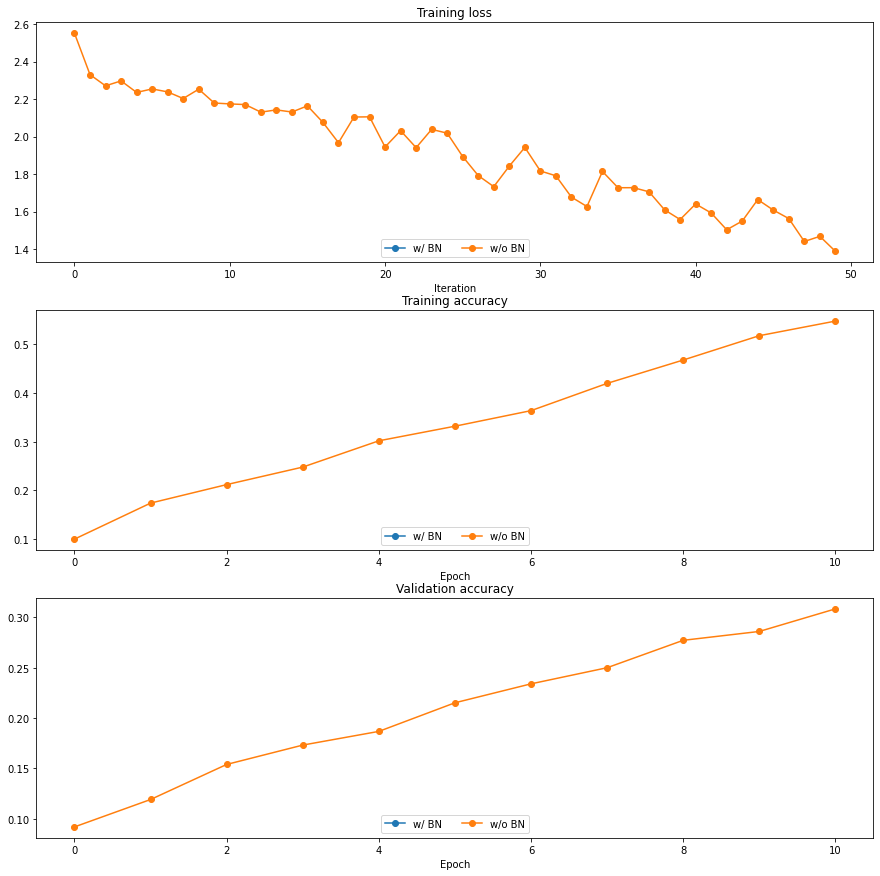

In [ ]:
plt.subplot(3, 1, 1)
plot_training_history_bn('Training loss','Iteration', [solver], [bn_solver], \
                      lambda x: x.loss_history, bl_marker='-o', bn_marker='-o')
plt.subplot(3, 1, 2)
plot_training_history_bn('Training accuracy','Epoch', [solver], [bn_solver], \
                      lambda x: x.train_acc_history, bl_marker='-o', bn_marker='-o')
plt.subplot(3, 1, 3)
plot_training_history_bn('Validation accuracy','Epoch', [solver], [bn_solver], \
                      lambda x: x.val_acc_history, bl_marker='-o', bn_marker='-o')

plt.gcf().set_size_inches(15, 15)
plt.show()

# Batch normalization and learning rate
We will now run a small experiment to study the interaction of batch normalization and learning rate.

The first cell will train convolutional networks with different learning rates. The second layer will plot training accuracy and validation set accuracy over time. You should find that using batch normalization helps the network to be less dependent to the learning rate.

In [ ]:
fix_random_seed(0)

# Try training a very deep net with batchnorm
num_train = 10000
small_data = {
  'X_train': data_dict['X_train'][:num_train],
  'y_train': data_dict['y_train'][:num_train],
  'X_val': data_dict['X_val'],
  'y_val': data_dict['y_val'],
}
input_dims = data_dict['X_train'].shape[1:]
num_epochs = 5
lrs = [2e-1, 1e-1, 5e-2]
lrs = [5e-3, 1e-2, 2e-2]

solvers = []
for lr in lrs:
  print('No normalization: learning rate = ', lr)
  model = DeepConvNet(input_dims=input_dims, num_classes=10,
                      num_filters=[8, 8, 8],
                      max_pools=[0, 1, 2],
                      weight_scale='kaiming',
                      batchnorm=False,
                      reg=1e-5, **to_float_cuda)
  solver = Solver(model, small_data,
                  num_epochs=num_epochs, batch_size=100,
                  update_rule=sgd_momentum,
                  optim_config={
                    'learning_rate': lr,
                  },
                  verbose=False, device='cuda')
  solver.train()
  solvers.append(solver)

bn_solvers = []
for lr in lrs:
  print('Normalization: learning rate = ', lr)
  bn_model = DeepConvNet(input_dims=input_dims, num_classes=10,
                         num_filters=[8, 8, 16, 16, 32, 32],
                         max_pools=[1, 3, 5],
                         weight_scale='kaiming',
                         batchnorm=True,
                         reg=1e-5, **to_float_cuda)
  bn_solver = Solver(bn_model, small_data,
                     num_epochs=num_epochs, batch_size=128,
                     update_rule=sgd_momentum,
                     optim_config={
                       'learning_rate': lr,
                     },
                     verbose=False, device='cuda')
  bn_solver.train()
  bn_solvers.append(bn_solver)

In [ ]:
plt.subplot(2, 1, 1)
plot_training_history_bn('Training accuracy (Batch Normalization)','Epoch', solvers, bn_solvers, \
                      lambda x: x.train_acc_history, bl_marker='-^', bn_marker='-o', labels=[' lr={:.0e}'.format(lr) for lr in lrs])
plt.subplot(2, 1, 2)
plot_training_history_bn('Validation accuracy (Batch Normalization)','Epoch', solvers, bn_solvers, \
                      lambda x: x.val_acc_history, bl_marker='-^', bn_marker='-o', labels=[' lr={:.0e}'.format(lr) for lr in lrs])

plt.gcf().set_size_inches(15, 10)
plt.show()